## Importando bibliotecas e base

In [1]:
from warnings import filterwarnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import time
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.mixture import GaussianMixture
from util import *
import joblib

filterwarnings('ignore')
pd.set_option('display.max_columns', None)

/home/jean/projetos/clustering-crm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet("../data/processed/df.parquet")
display(df.head())

,IDCliente,AnoDeNascimento,NivelDeEducacao,EstadoCivil,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DataDeInscricao,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,GastoComFrutasNosUltimos2Anos,GastoComCarneNosUltimos2Anos,GastoComPeixeNosUltimos2Anos,GastoComDocesNosUltimos2Anos,GastoComOuroNosUltimos2Anos,ComprasComDesconto,ComprasNoWeb,ComprasPorCatalogo,ComprasNaLoja,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha,AceitouAlgumaCampanha,Idade,DiasDesdeInscricao,TotalPessoasNaCasa,RendaAnualPerCapitaFamiliar,TotalCompras,Frequencia,ValorTotal,Ticket_Medio
0,5524,1957,Graduação,Solteiro(a),58138.0,0,0,2021-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,1,68,1620,1,58138.0,25,0.015432,1617,64.680000
1,2174,1954,Graduação,Solteiro(a),46344.0,1,1,2023-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,0,71,774,3,15448.0,6,0.007752,27,4.500000
2,4141,1965,Graduação,União Estável,71613.0,0,0,2022-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,0,60,1121,2,35806.5,21,0.018733,776,36.952381
3,6182,1984,Graduação,União Estável,26646.0,1,0,2023-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,0,41,714,3,8882.0,8,0.011204,53,6.625000
4,5324,1981,Doutorado,Casado(a),58293.0,1,0,2023-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,0,44,970,3,19431.0,19,0.019588,422,22.210526


## Preparação dos Dados

In [3]:
X = df.drop(columns=['IDCliente','AnoDeNascimento','DataDeInscricao'])

cat_attributes = X.select_dtypes(include='object')
num_attributes = X.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Define numerical pipeline with RobustScaler
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Aplica o pipeline à base de dados
X_processed = pipeline.fit_transform(X)

# Obtém os nomes das colunas após o one-hot encoding
encoded_cat_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names_out(input_features=cat_attributes.columns)

# Combina os nomes das colunas categóricas codificadas e as colunas numéricas
all_columns = list(encoded_cat_columns) + list(num_attributes.columns)

# Cria um DataFrame com as colunas pré-processadas e seus nomes
df_X_processed = pd.DataFrame(X_processed, columns=all_columns)


In [4]:
# Salvando os objetos com joblib
joblib.dump(pipeline, '../artifacts/preprocessing_pipeline.joblib')
joblib.dump(all_columns, '../artifacts/feature_names.joblib')

['../artifacts/feature_names.joblib']

## Redução de Dimensionalidade

In [5]:
df_X_processed.shape

(2240, 44)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.90)
pca.fit(df_X_processed)
df_reduced = pca.transform(df_X_processed)
df_reduced.shape

(2240, 15)

In [7]:
# Salvando os objetos com joblib
joblib.dump(pca, '../artifacts/pca_model.joblib')

['../artifacts/pca_model.joblib']

## Modelagem - Clusterização
### K-MEANS

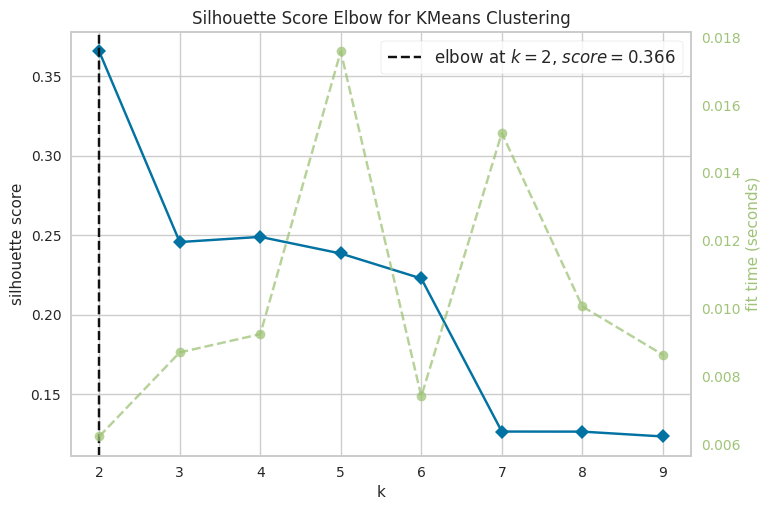

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"

# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=0, n_init='auto')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette', timings= True);
visualizer.fit(df_reduced)        # Fit the data to the visualizer
visualizer.show();

In [19]:
# Treinar o algoritmo K-means com 4 clusters
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans.fit(df_reduced)

# Obter os centróides dos clusters
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

df['Cluster'] = labels

np.unique(labels)

array([0, 1], dtype=int32)

In [20]:
# Salvando os objetos com joblib
joblib.dump(kmeans, '../artifacts/kmeans_model.joblib')

['../artifacts/kmeans_model.joblib']

Análise dos Clusters Gerados - K-MEANS

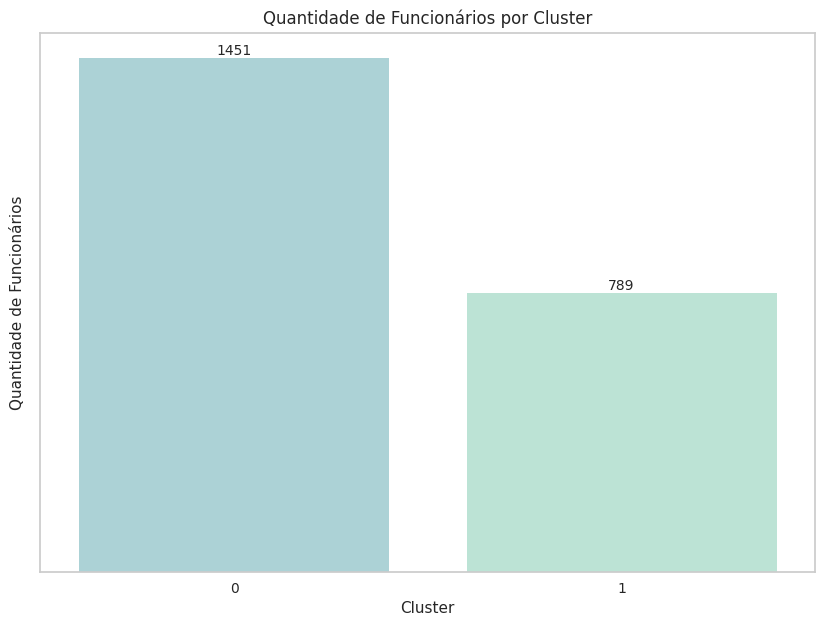

In [21]:
pal = ['#A5D8DD', '#B5EAD7', '#FFDAC1', '#E2F0CB', '#C7CEEA', '#F8B195', '#F67280', '#6C5B7B']
pal = pal[:len(np.unique(labels))]

plt.figure(figsize=(10,7))
pl = sns.countplot(data=df, x="Cluster", palette=pal)

for i in range(len(pl.containers)):
  pl.bar_label(pl.containers[i], fontsize=10)
pl.set_title("Quantidade de Funcionários por Cluster")
plt.gca().axes.yaxis.set_ticklabels([])
plt.ylabel('Quantidade de Funcionários')
plt.grid(False)
plt.show()

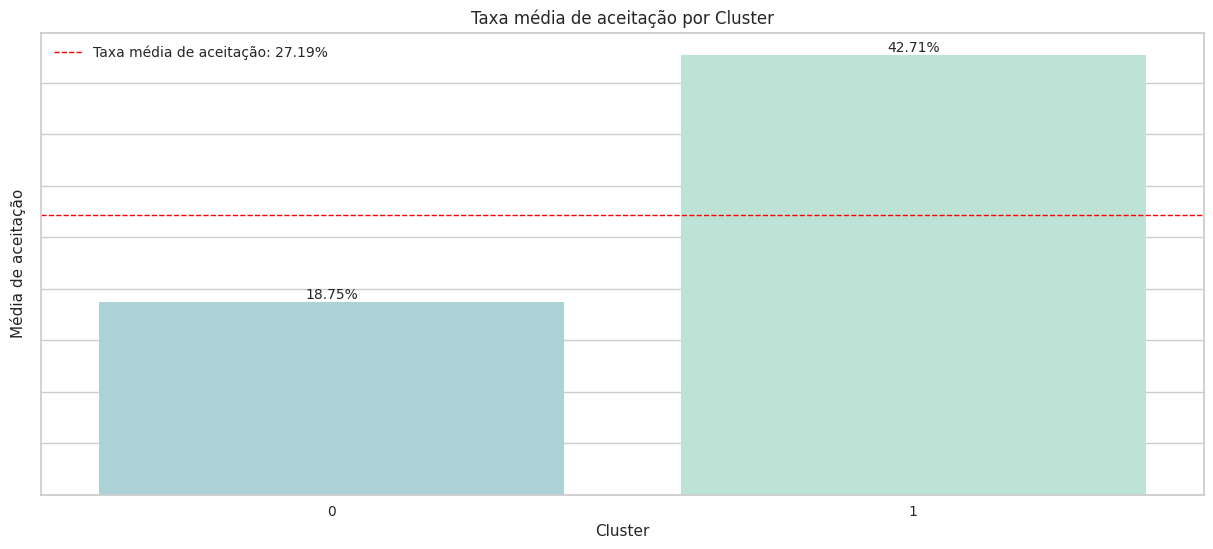

In [22]:
df['TARGET'] = (df['AceitouAlgumaCampanha'] == 1).astype(int)

# Calcular a média da variável "Rotatividade" para cada cluster
mean_rotatividade_by_cluster = df.groupby("Cluster")["TARGET"].mean().reset_index()

overall_mean_churn = df['TARGET'].mean()

# Plot the barplot
plt.figure(figsize=(15, 6))
sns.barplot(x="Cluster", y="TARGET", data=mean_rotatividade_by_cluster, palette=pal)

# Plot the overall mean churn rate as a dashed line
plt.axhline(overall_mean_churn, color='red', linestyle='dashed', linewidth=1, label='Taxa média de aceitação: {:.2f}%'.format(overall_mean_churn * 100))

plt.title("Taxa média de aceitação por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Média de aceitação")

# Add the churn rate values on the bars
for i, taxa in enumerate(mean_rotatividade_by_cluster.TARGET.values):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

plt.gca().axes.yaxis.set_ticklabels([])
plt.legend()
plt.show()

## Categoricas

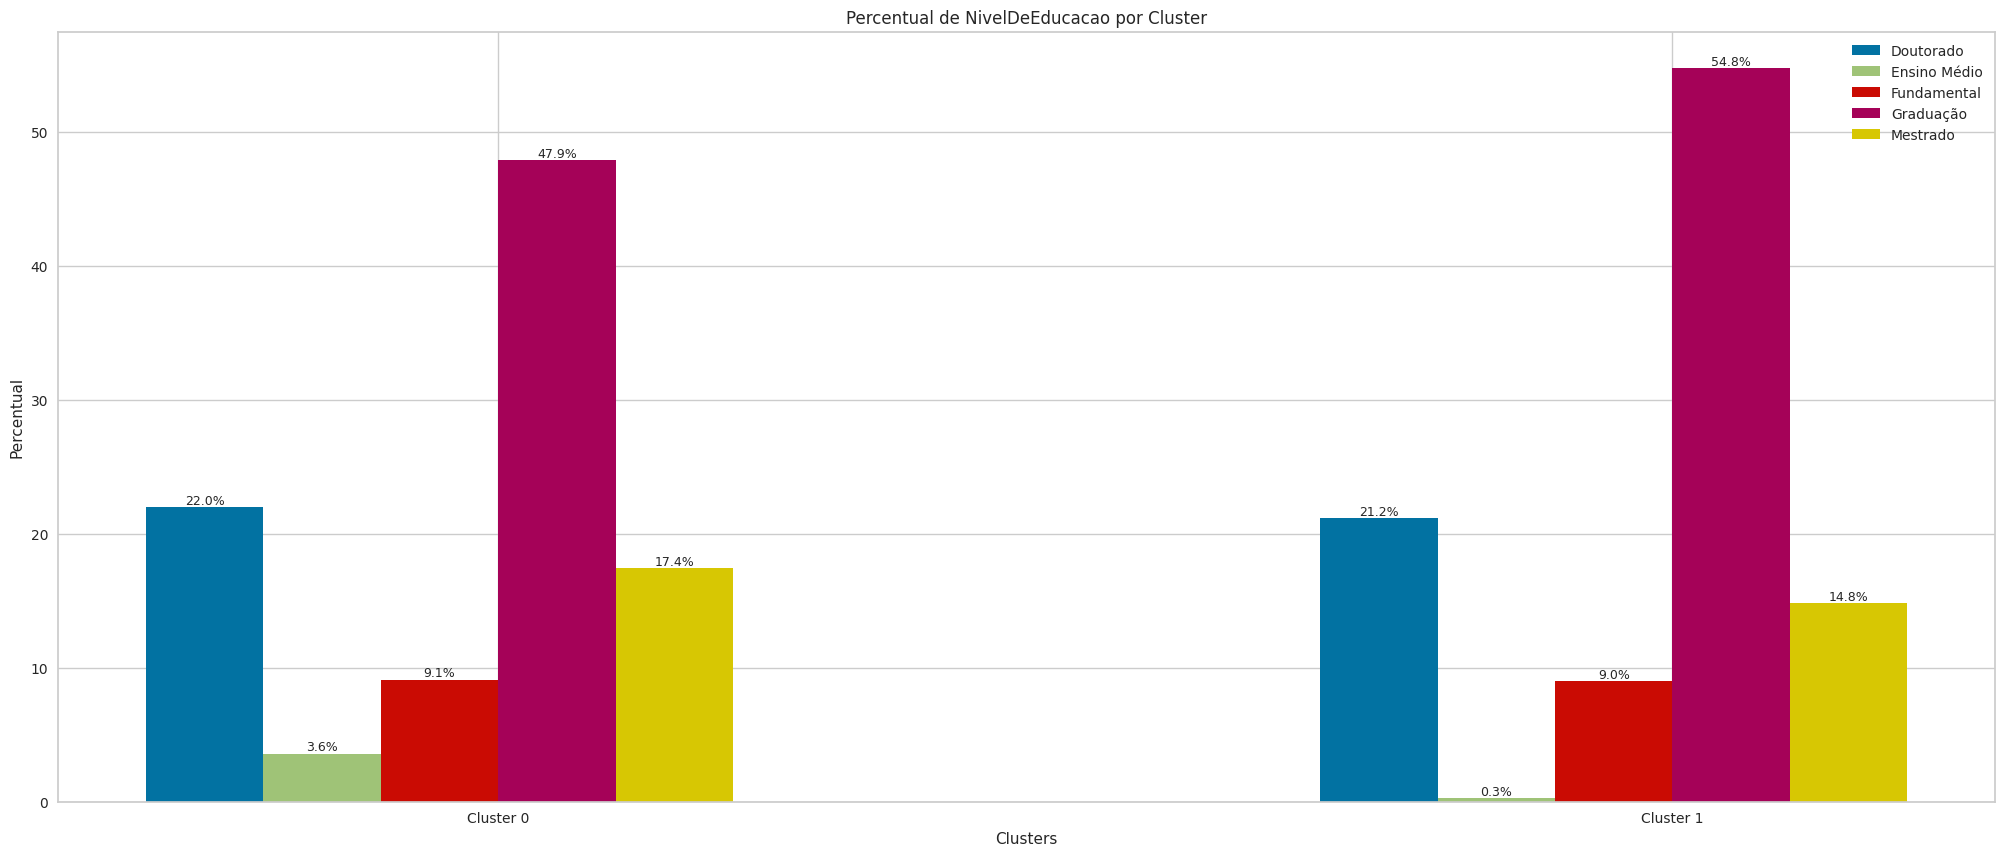

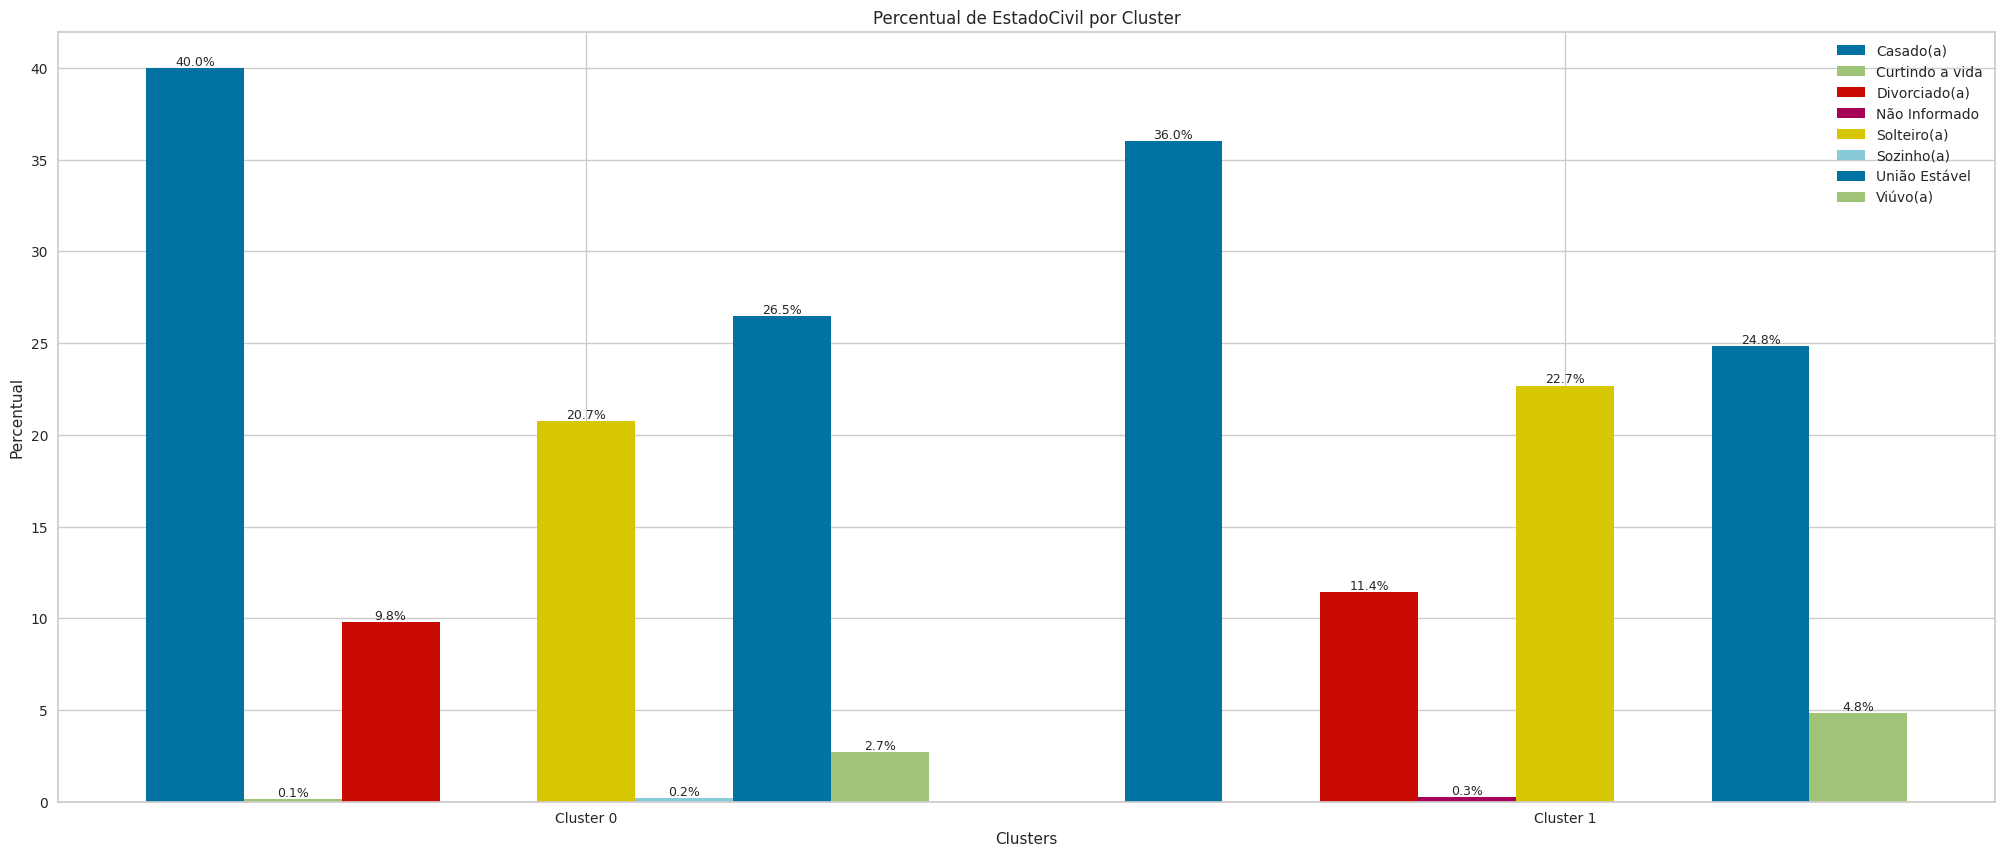

In [23]:
# Variáveis a serem analisadas:
vars1 = list(cat_attributes.columns).copy()

vars_categoricas = vars1

for var in vars_categoricas:
  percentuais_por_cluster = df.groupby('Cluster')[var].value_counts(normalize=True).mul(100).unstack().reset_index().values

  # Extrair os clusters e os percentuais de satisfação
  clusters = percentuais_por_cluster[:, 0]
  percentuais = percentuais_por_cluster[:, 1:]

  # Largura da barra
  bar_width = 0.1

  # Coordenadas das barras
  x = np.arange(len(clusters))

  # Plotar o gráfico de barras
  plt.figure(figsize=(25, 10))

  unicos = sorted(df[var].unique())
  for i in range(len(percentuais[0])):
      j = unicos[i]
      plt.bar(x + i * bar_width, percentuais[:, i], bar_width, label=f'{j}')
      for j, val in enumerate(percentuais[:, i]):
          plt.text(x[j] + i * bar_width, val, '{:.1f}%'.format(val), ha='center', va='bottom', fontsize=9);

  # Adicionar rótulos e título
  plt.xlabel('Clusters');
  plt.ylabel('Percentual');
  plt.title(f'Percentual de {var} por Cluster');
  plt.xticks(x + bar_width * len(percentuais[0]) / 2, [f'Cluster {int(cluster)}' for cluster in clusters]);
  plt.legend(loc='best');

  # Mostrar o gráfico
  plt.show();

## Númericas

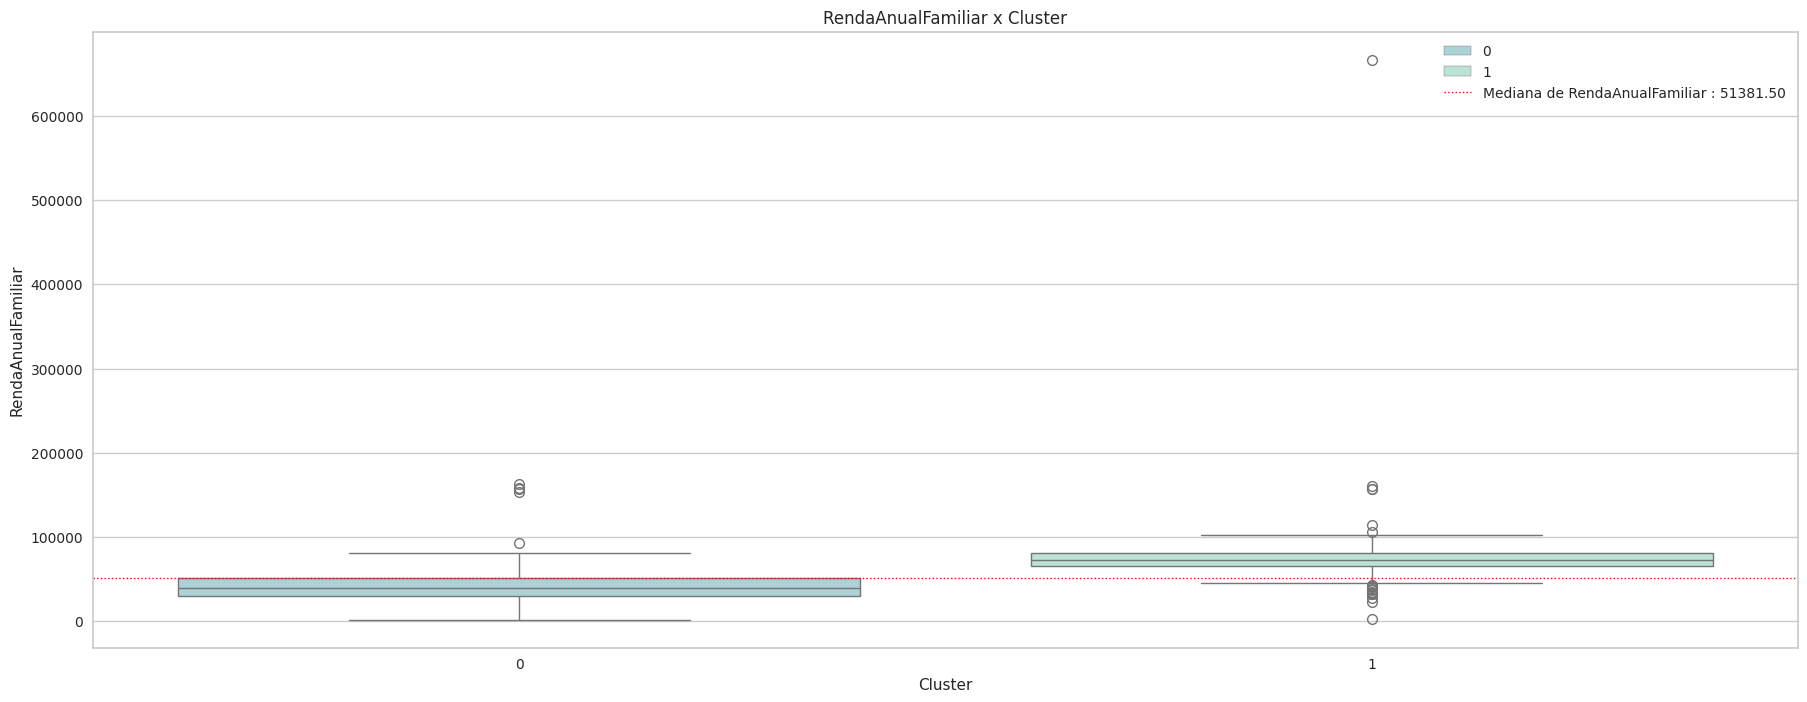

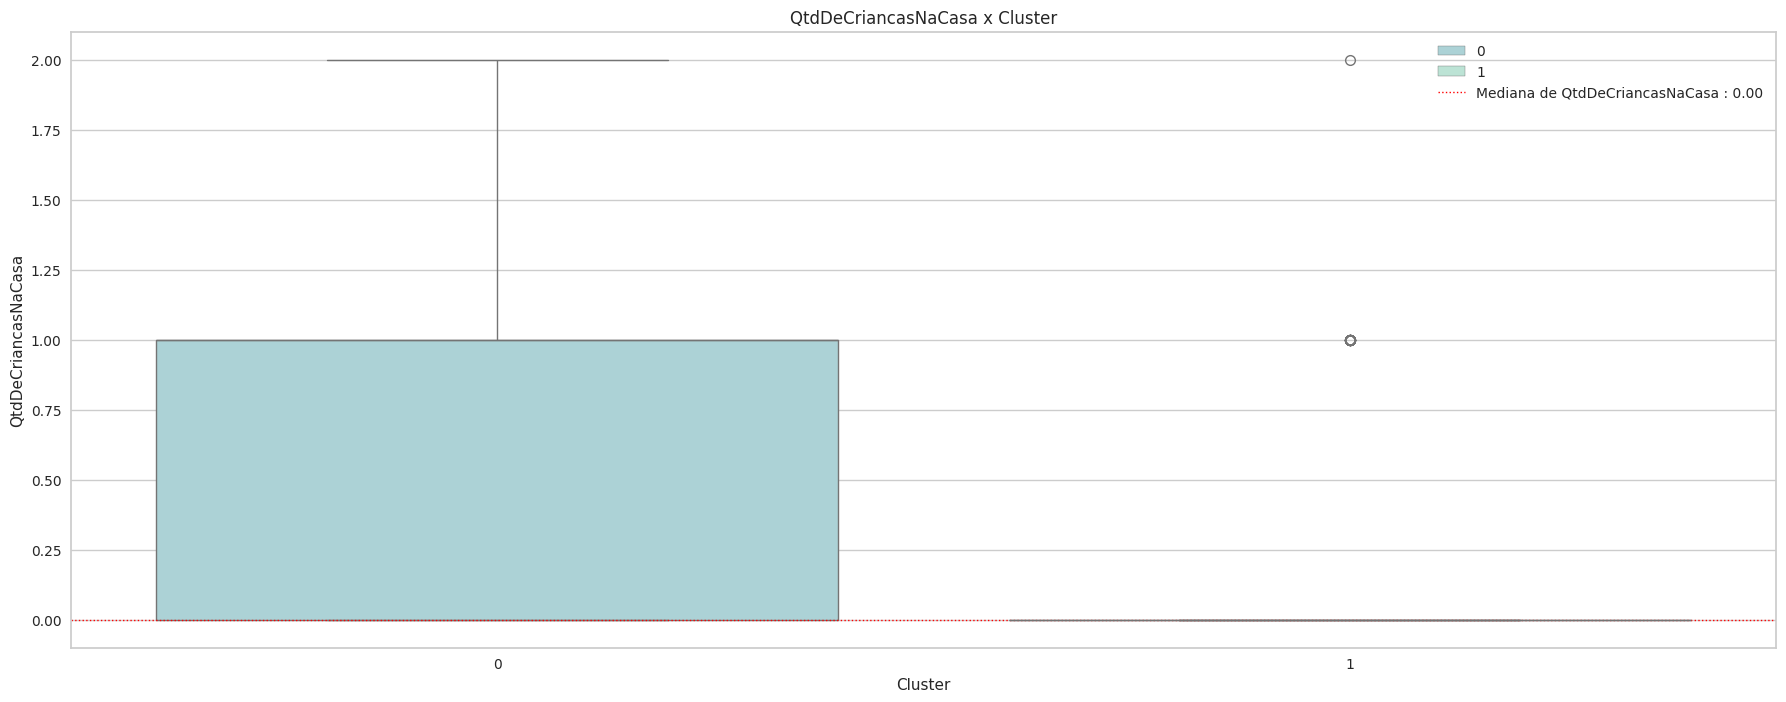

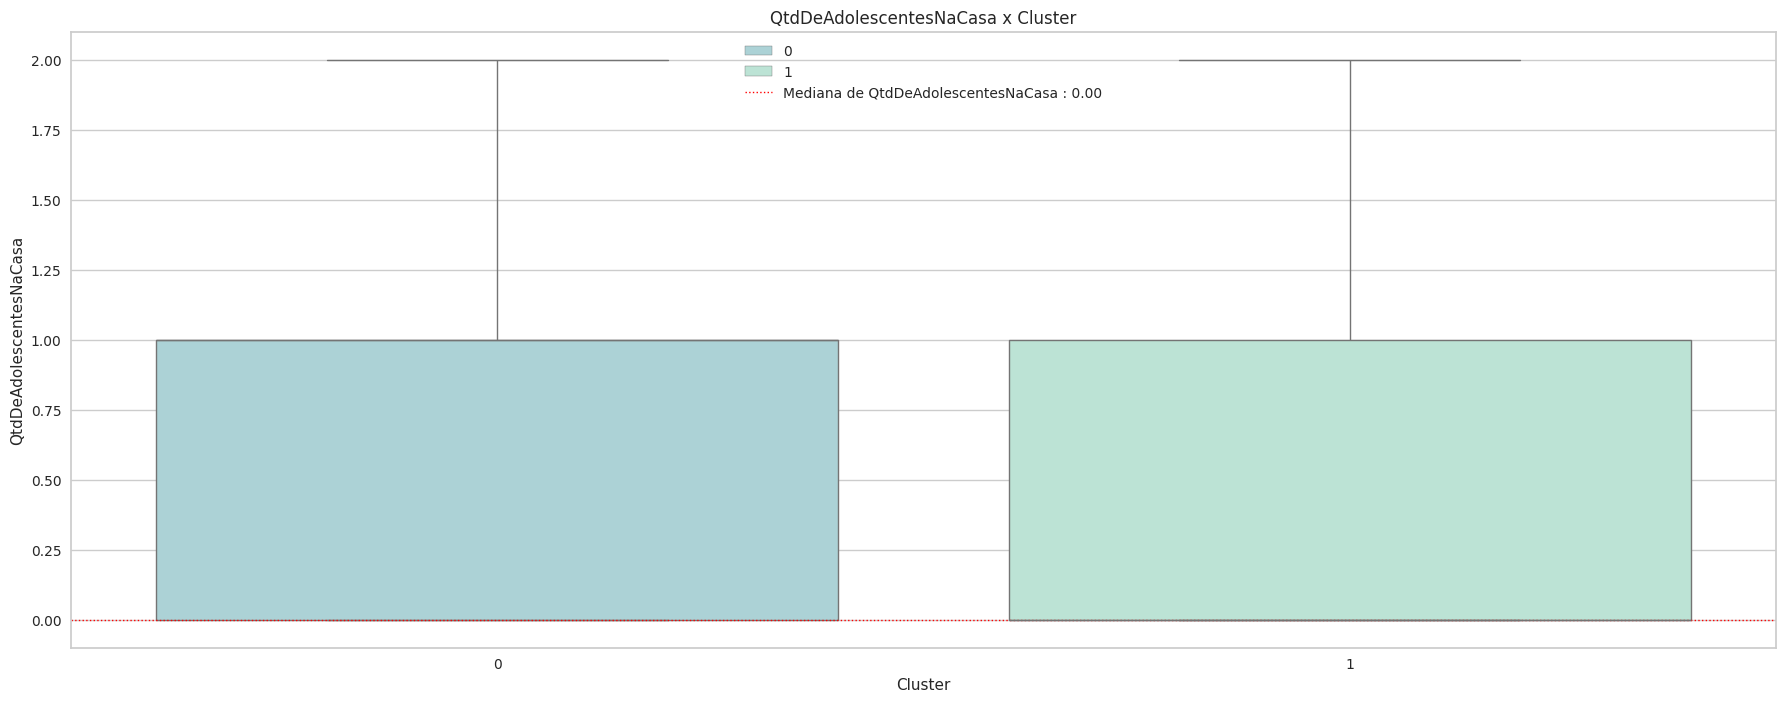

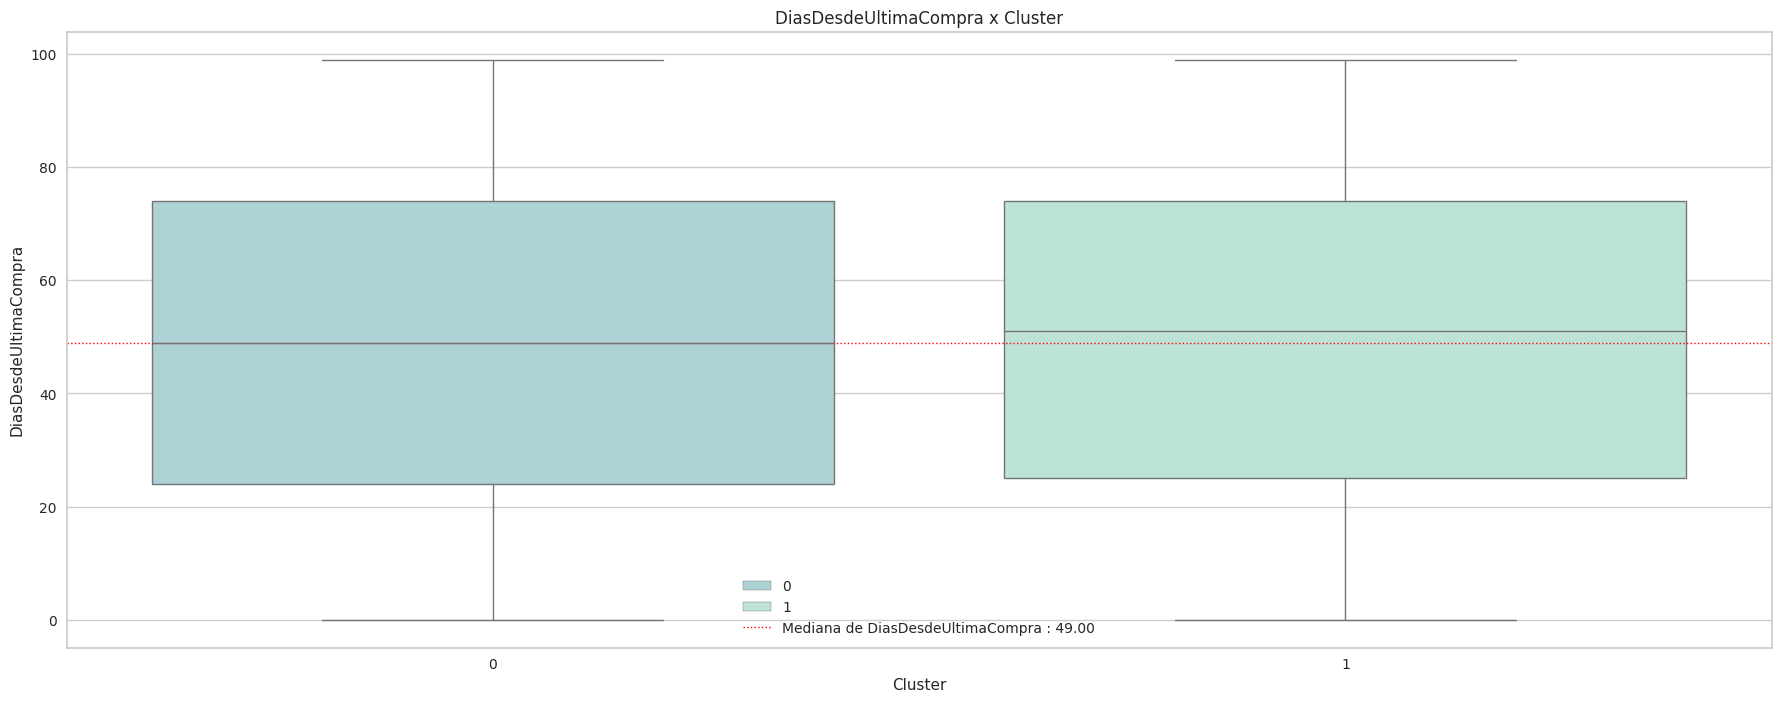

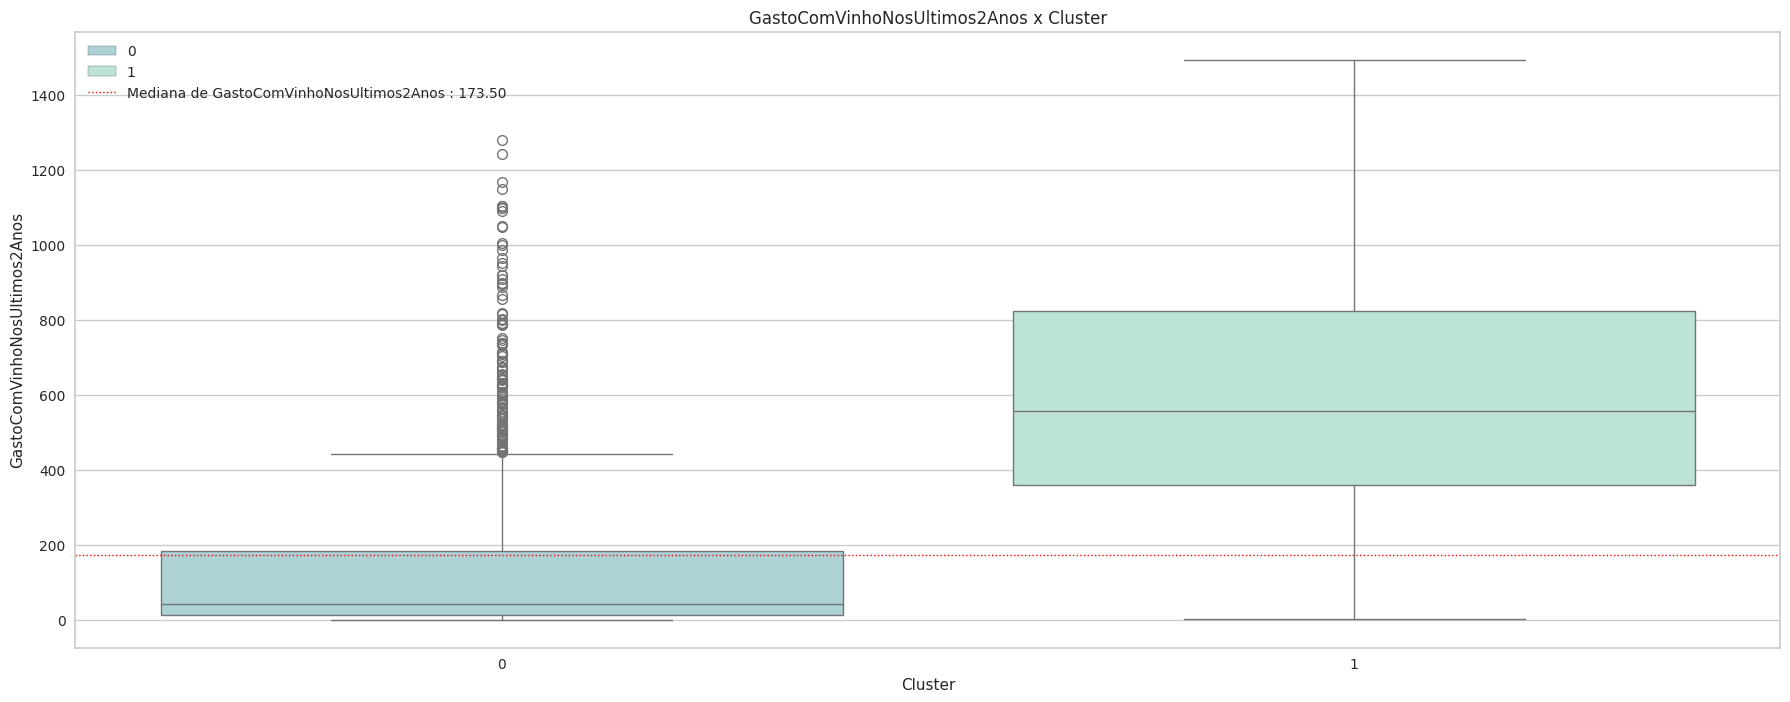

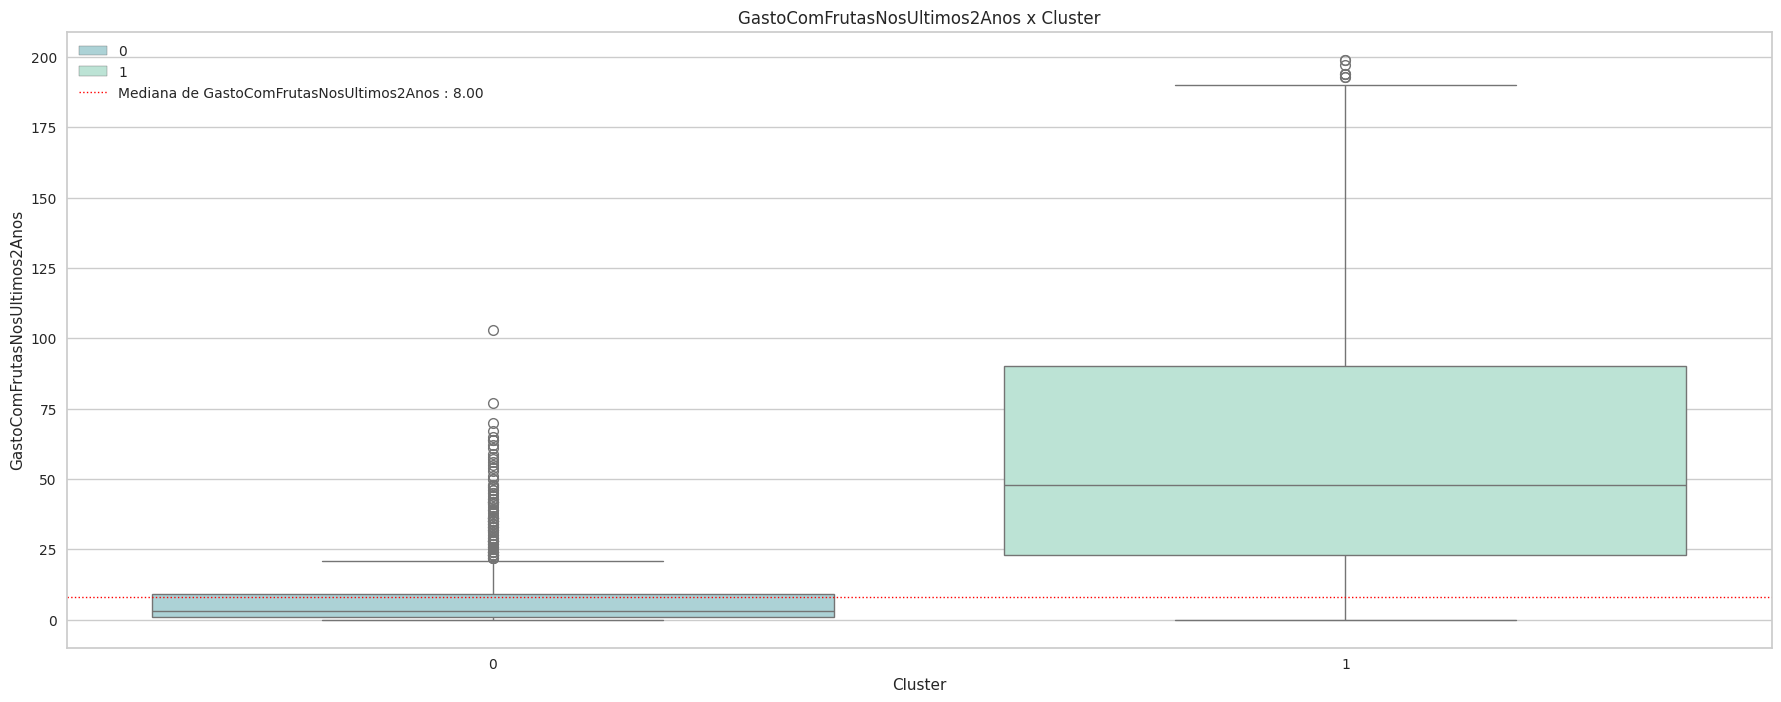

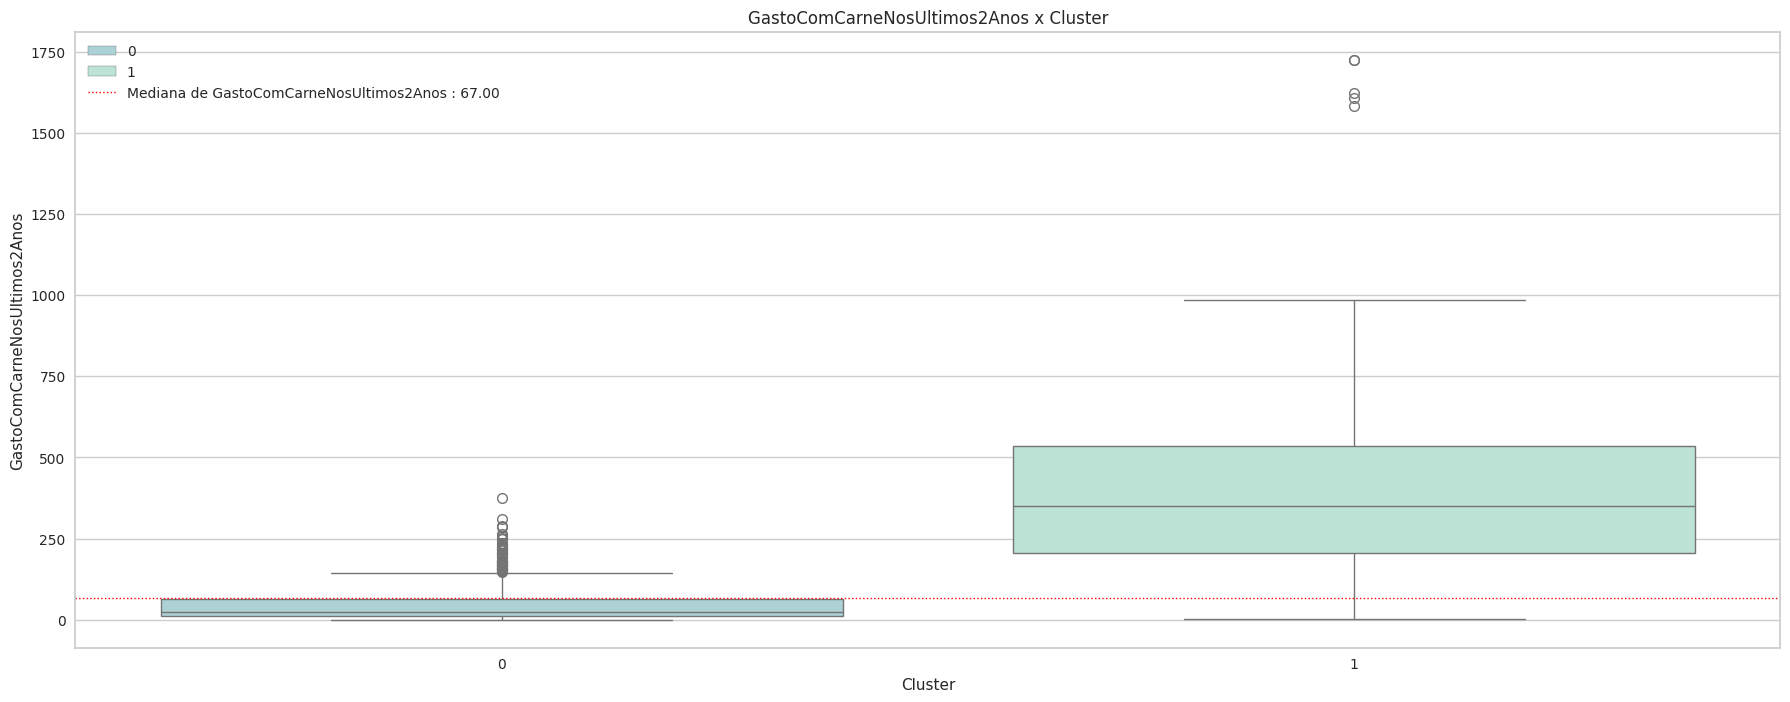

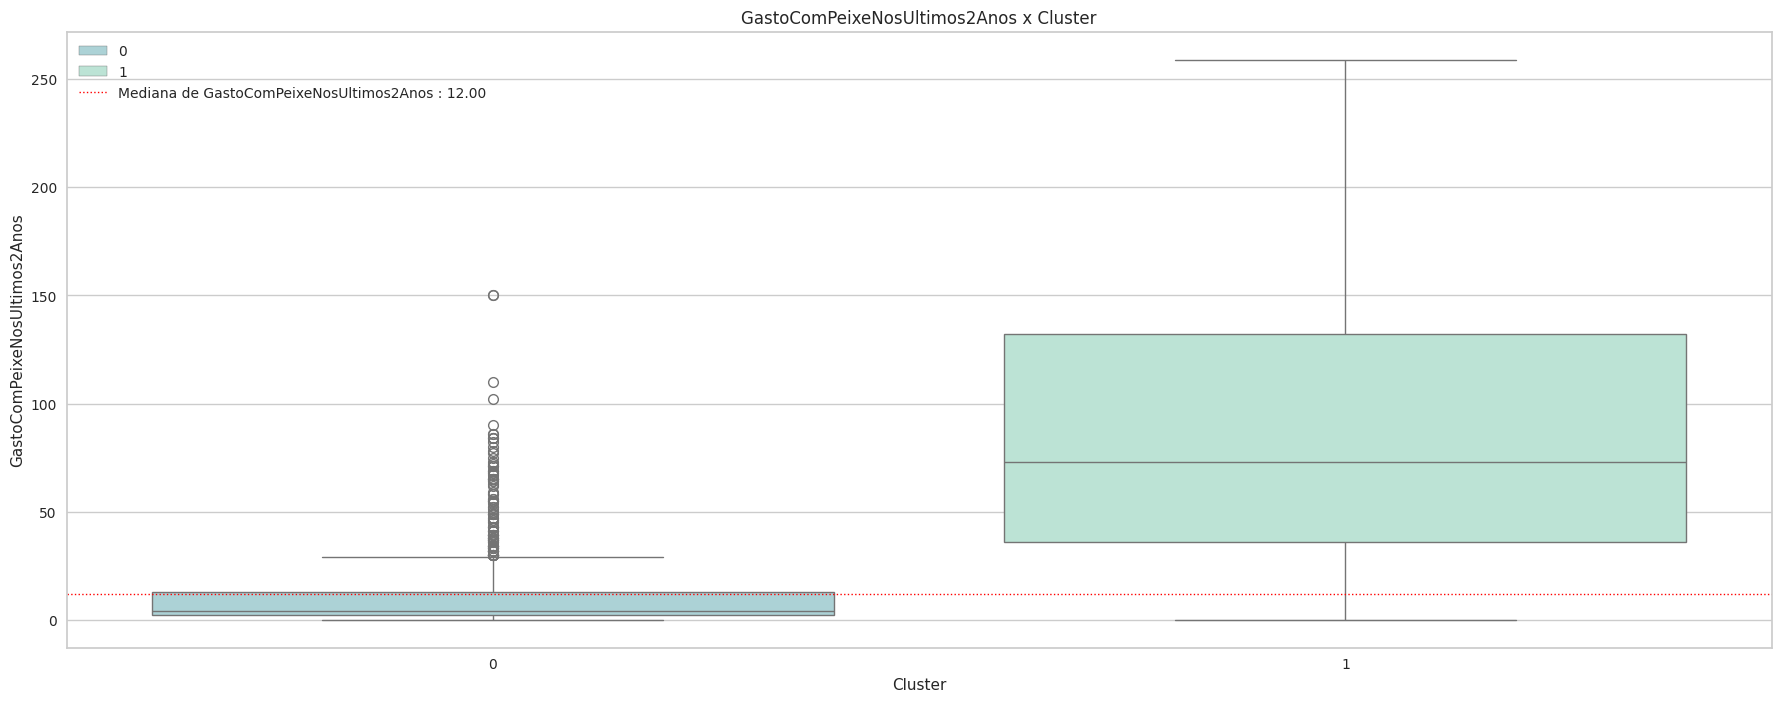

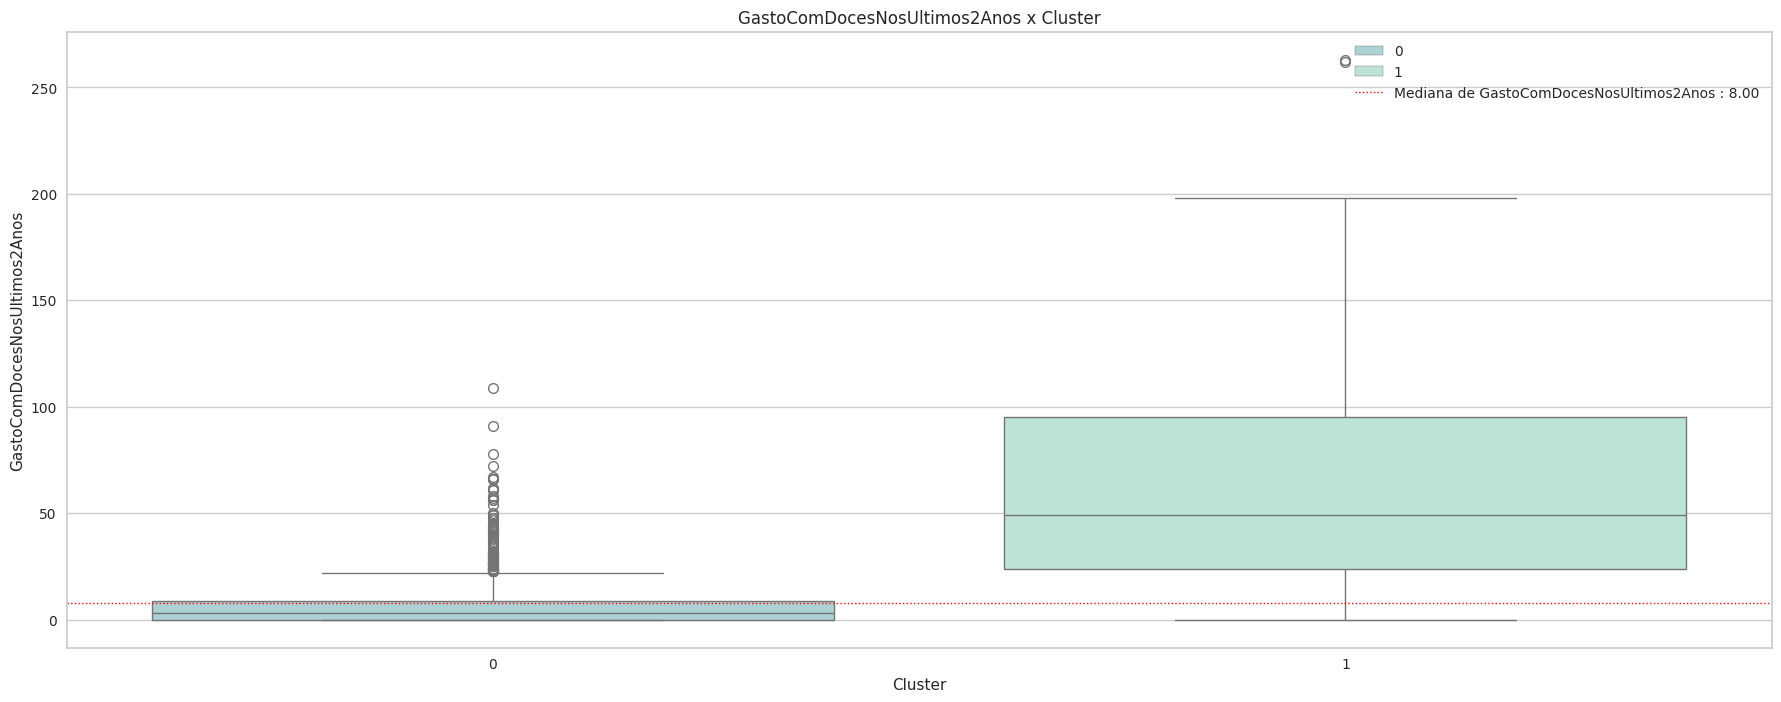

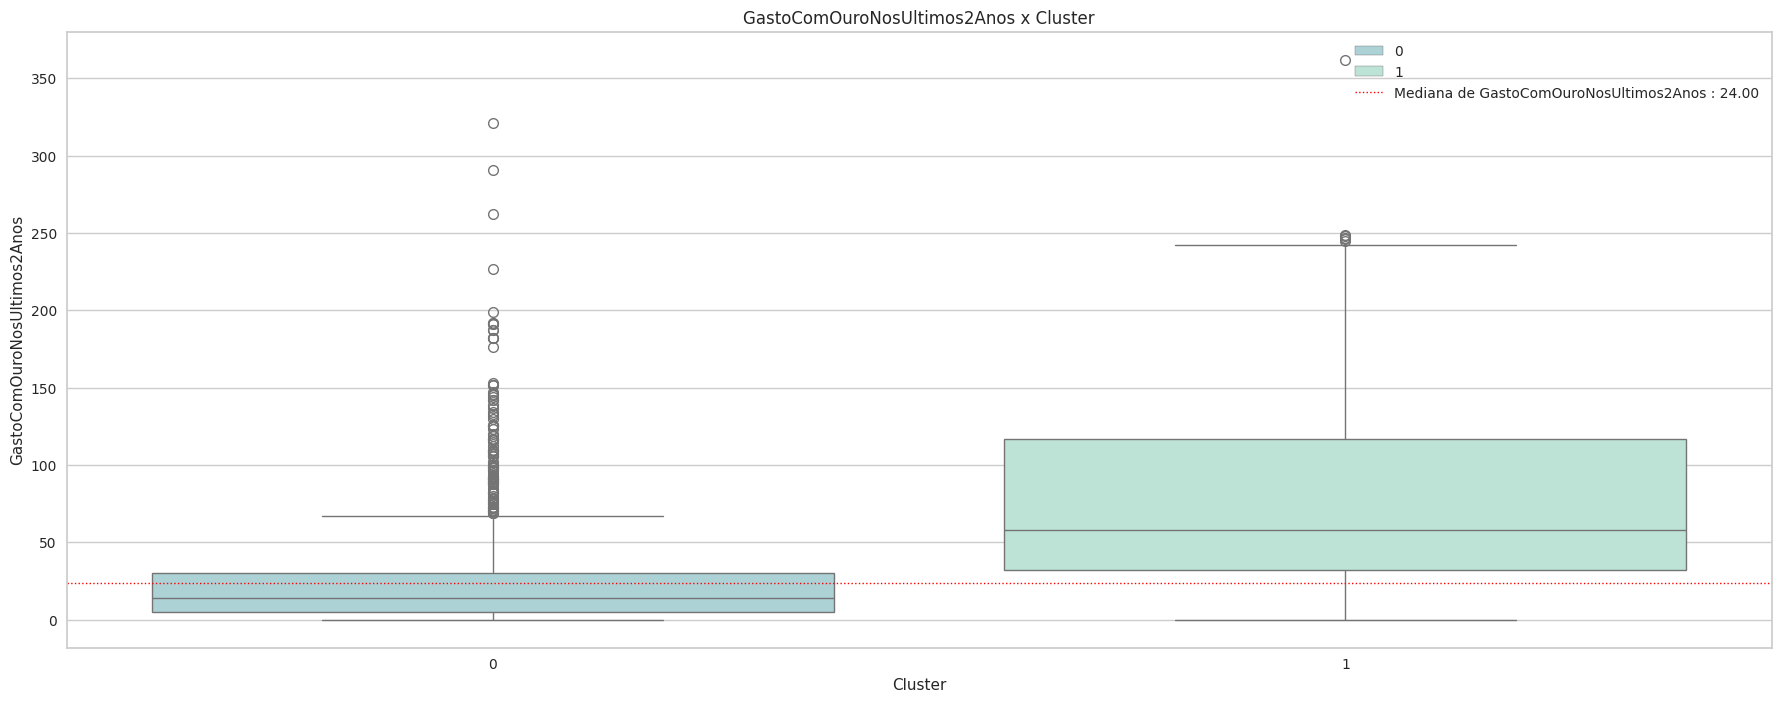

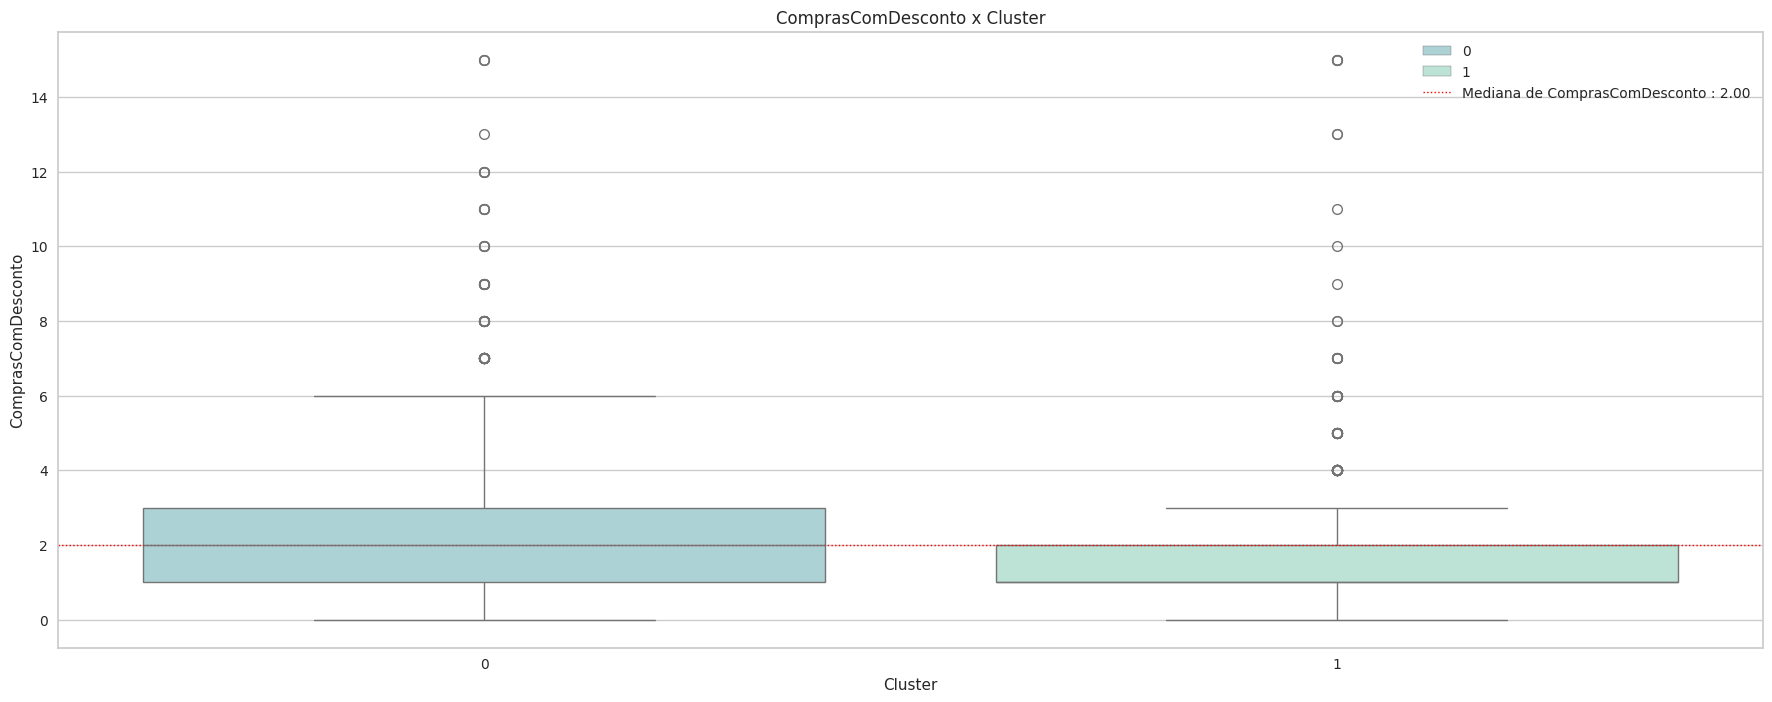

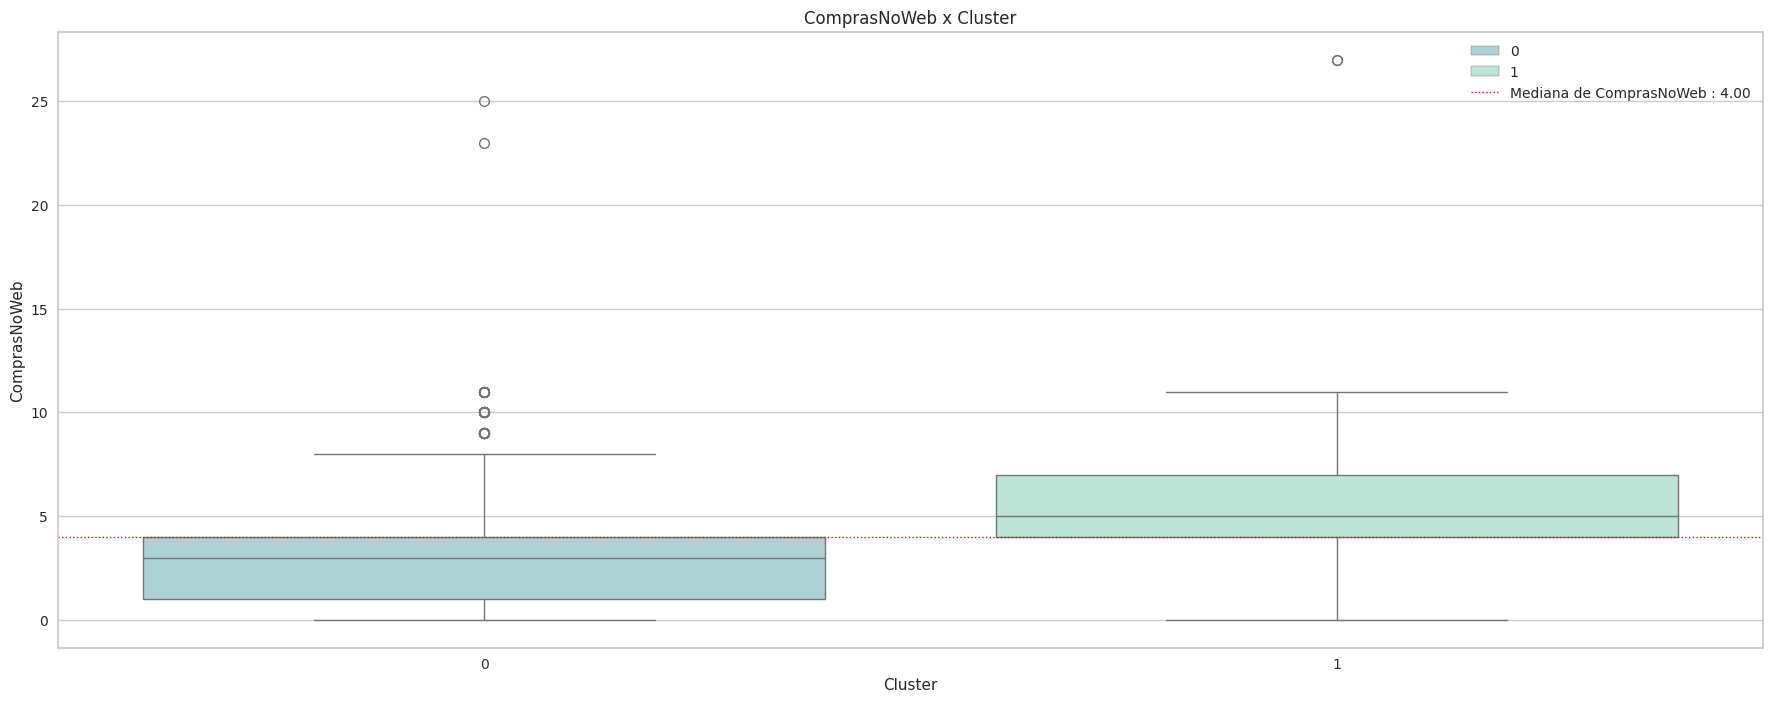

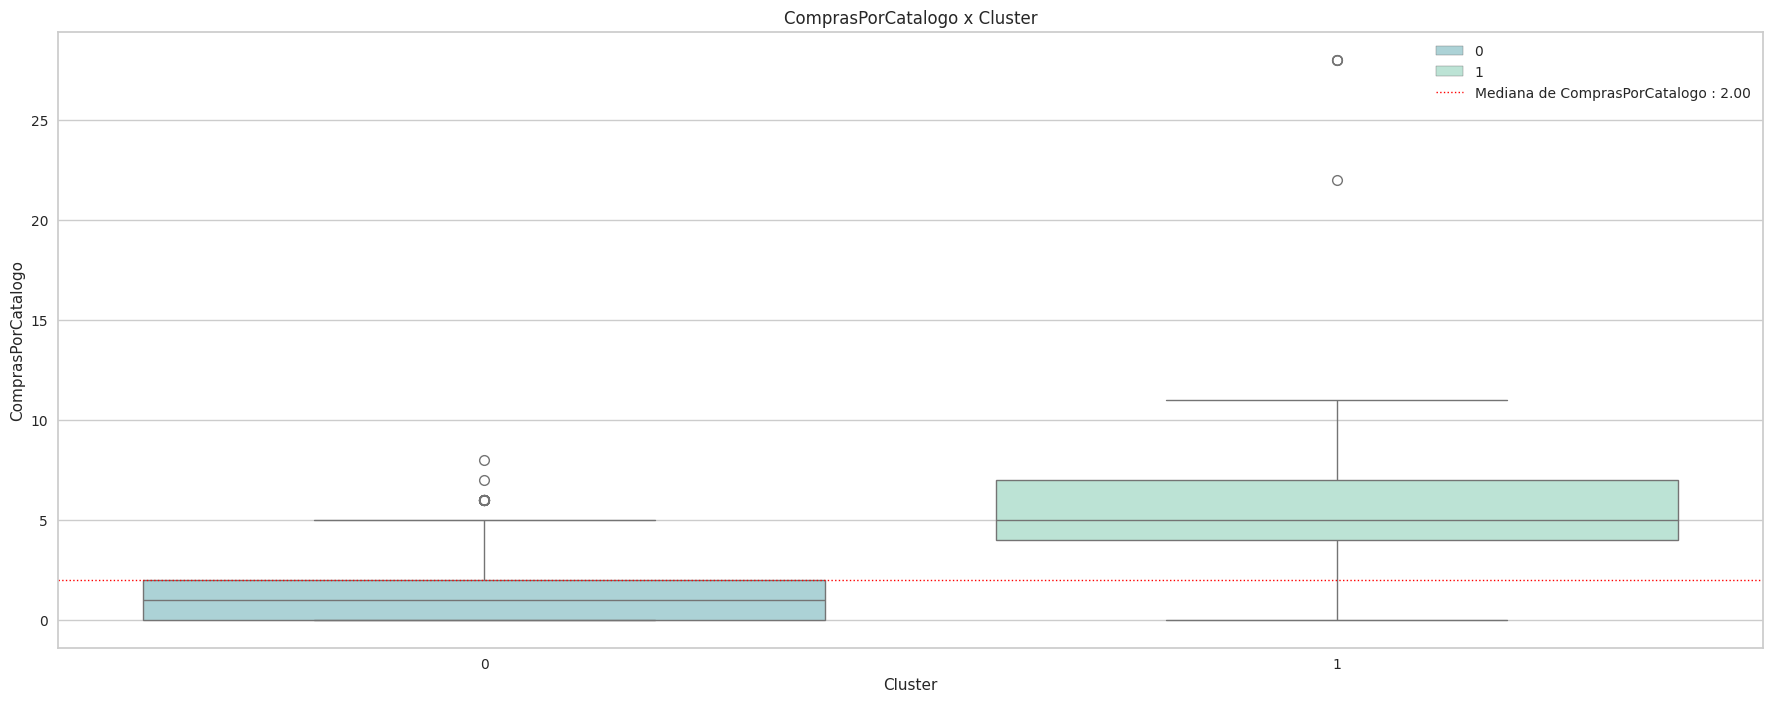

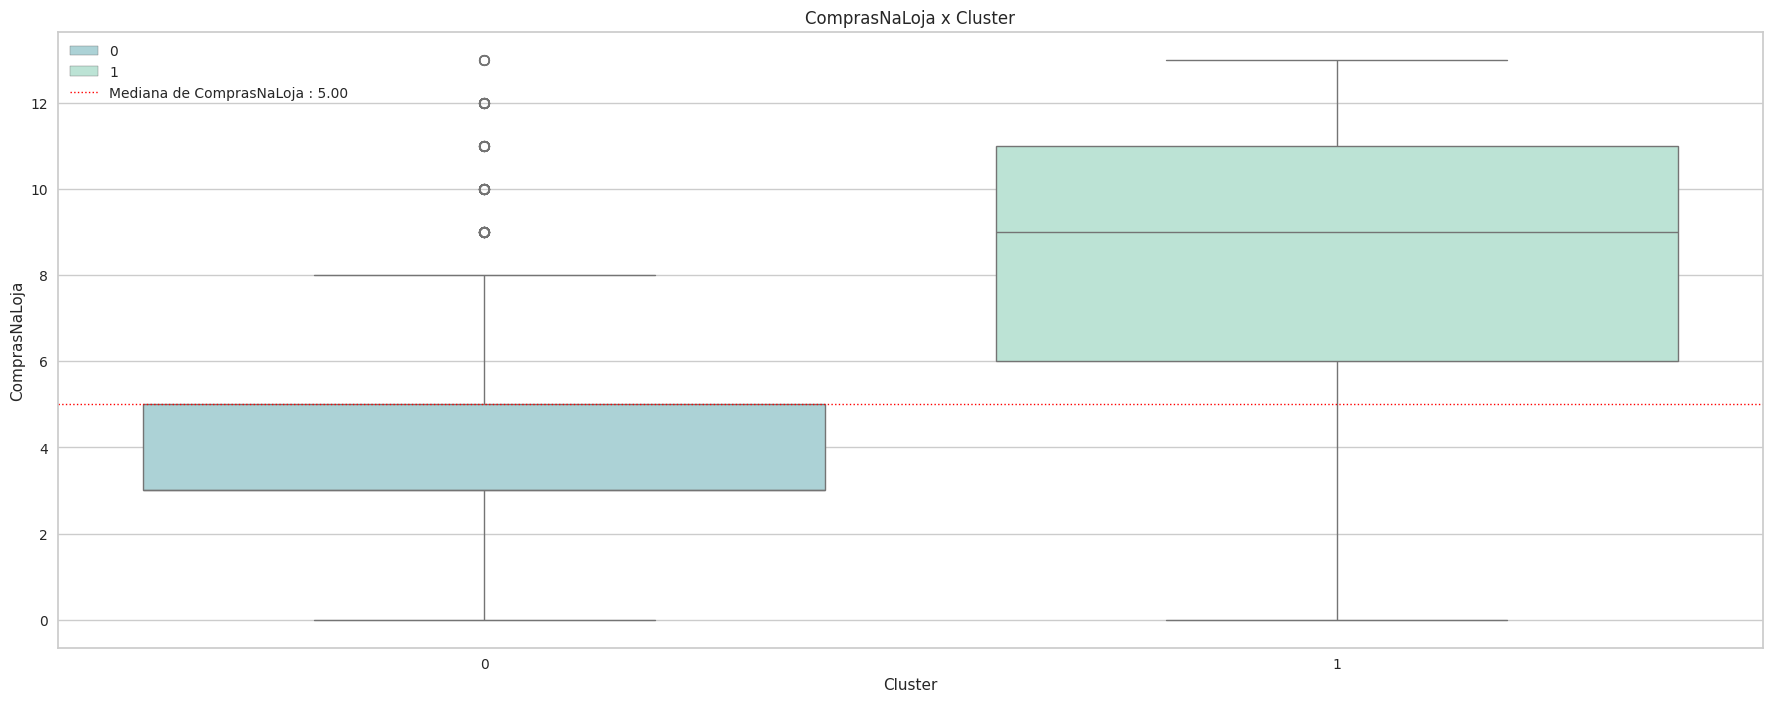

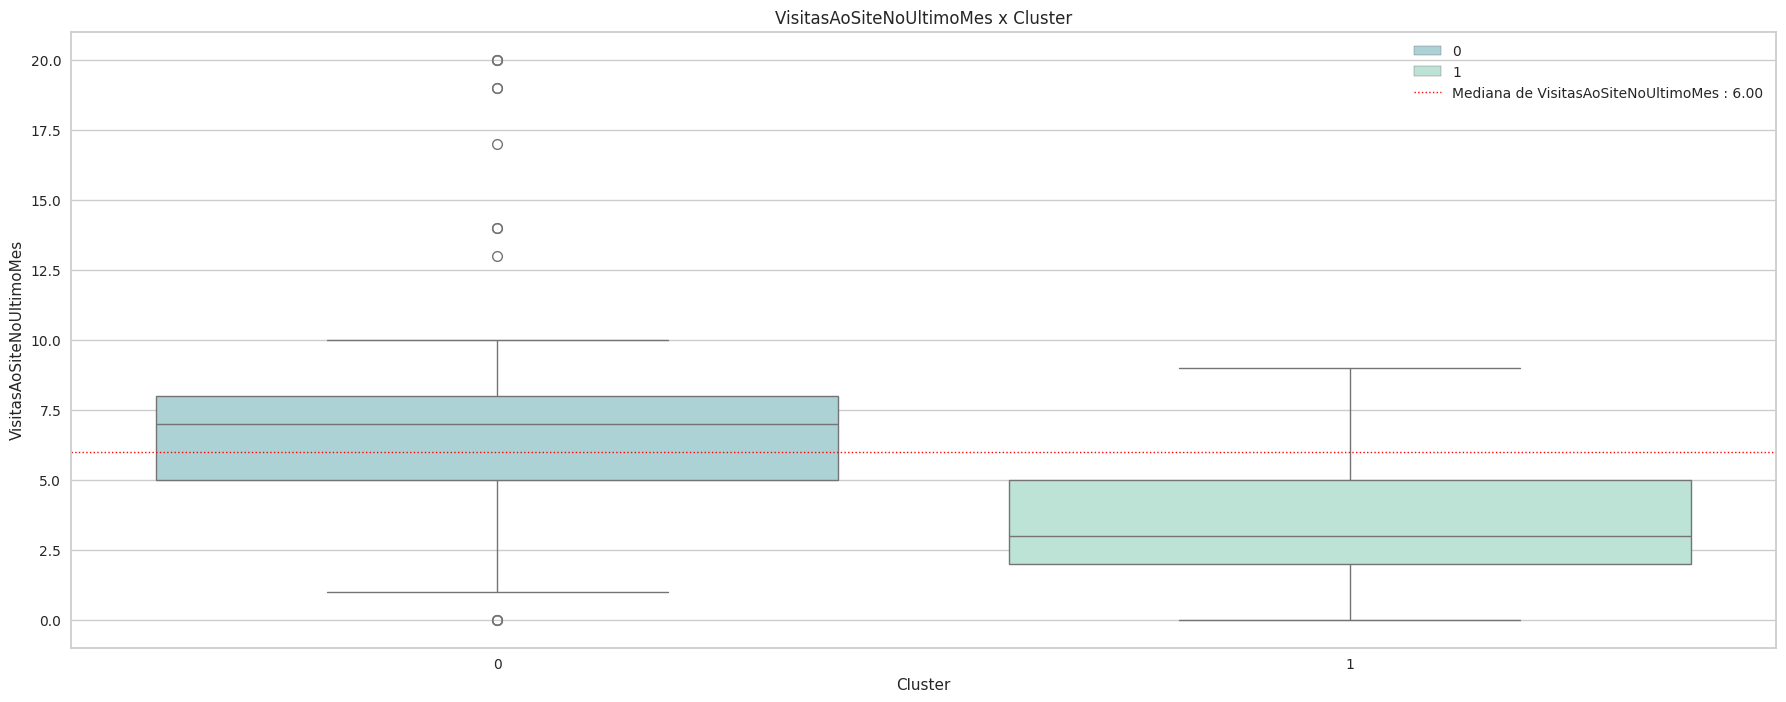

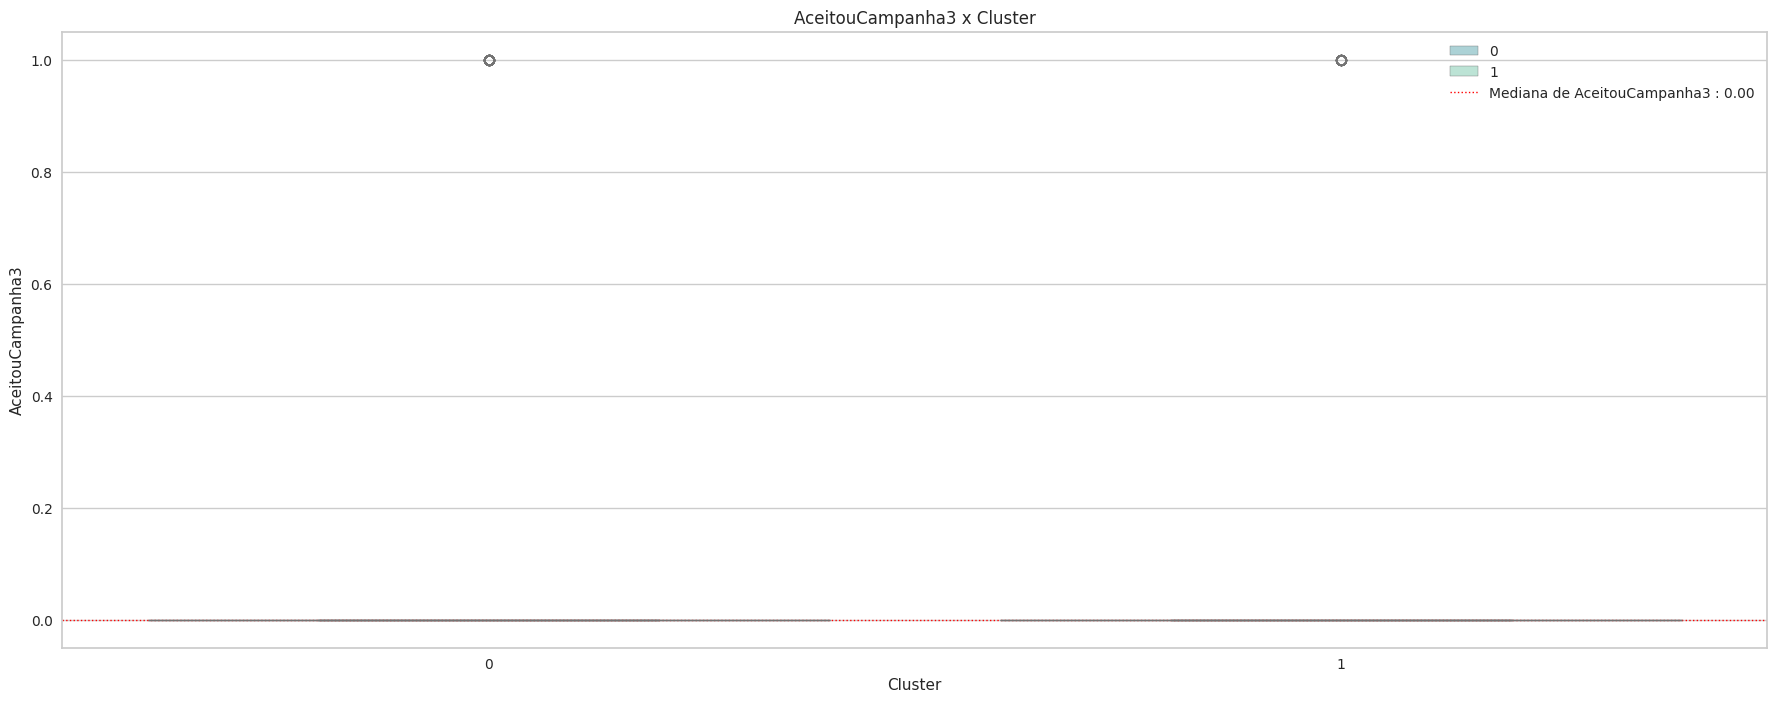

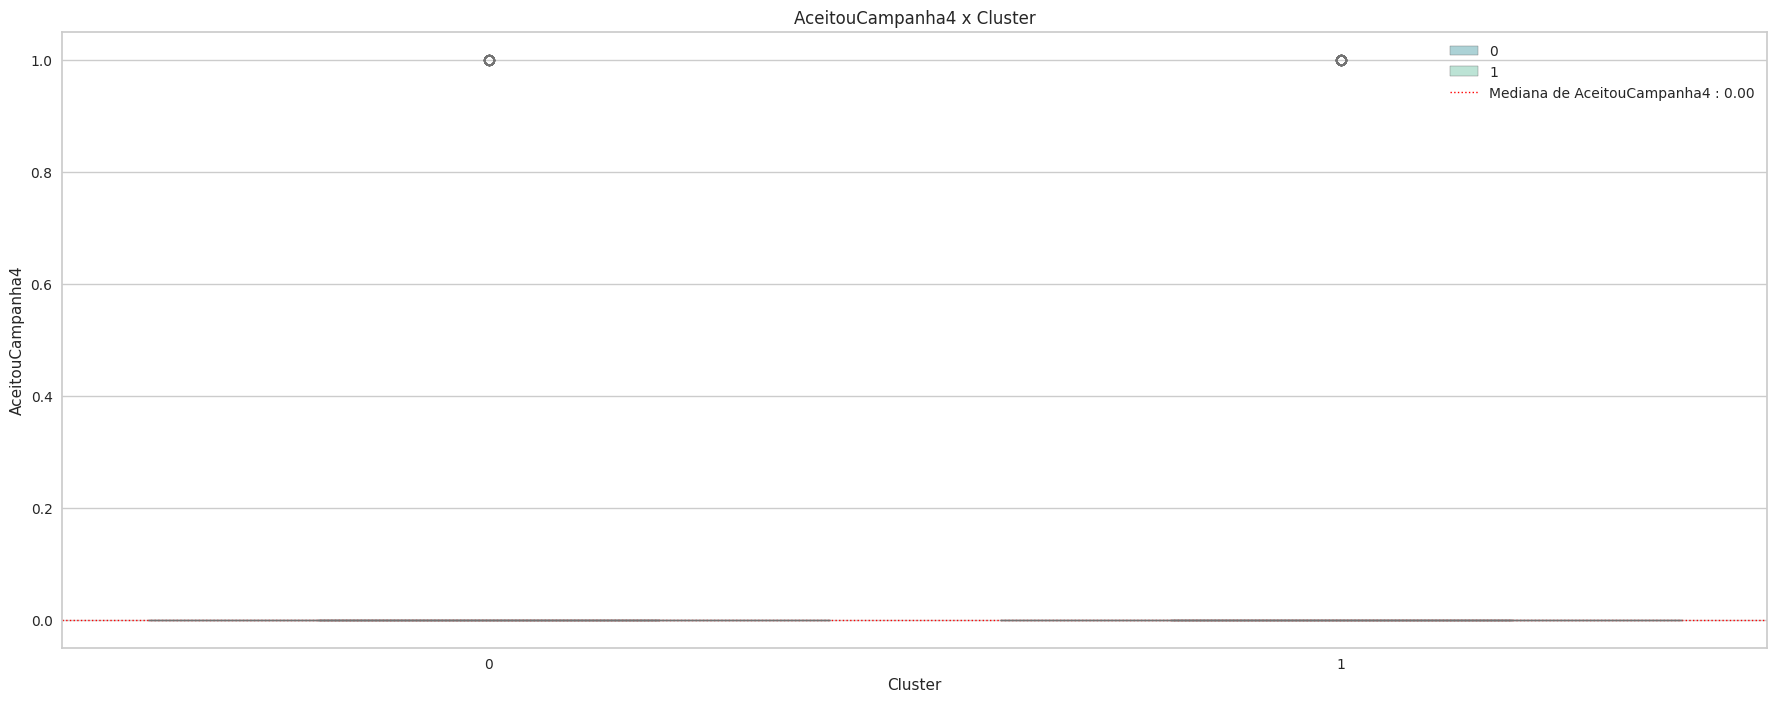

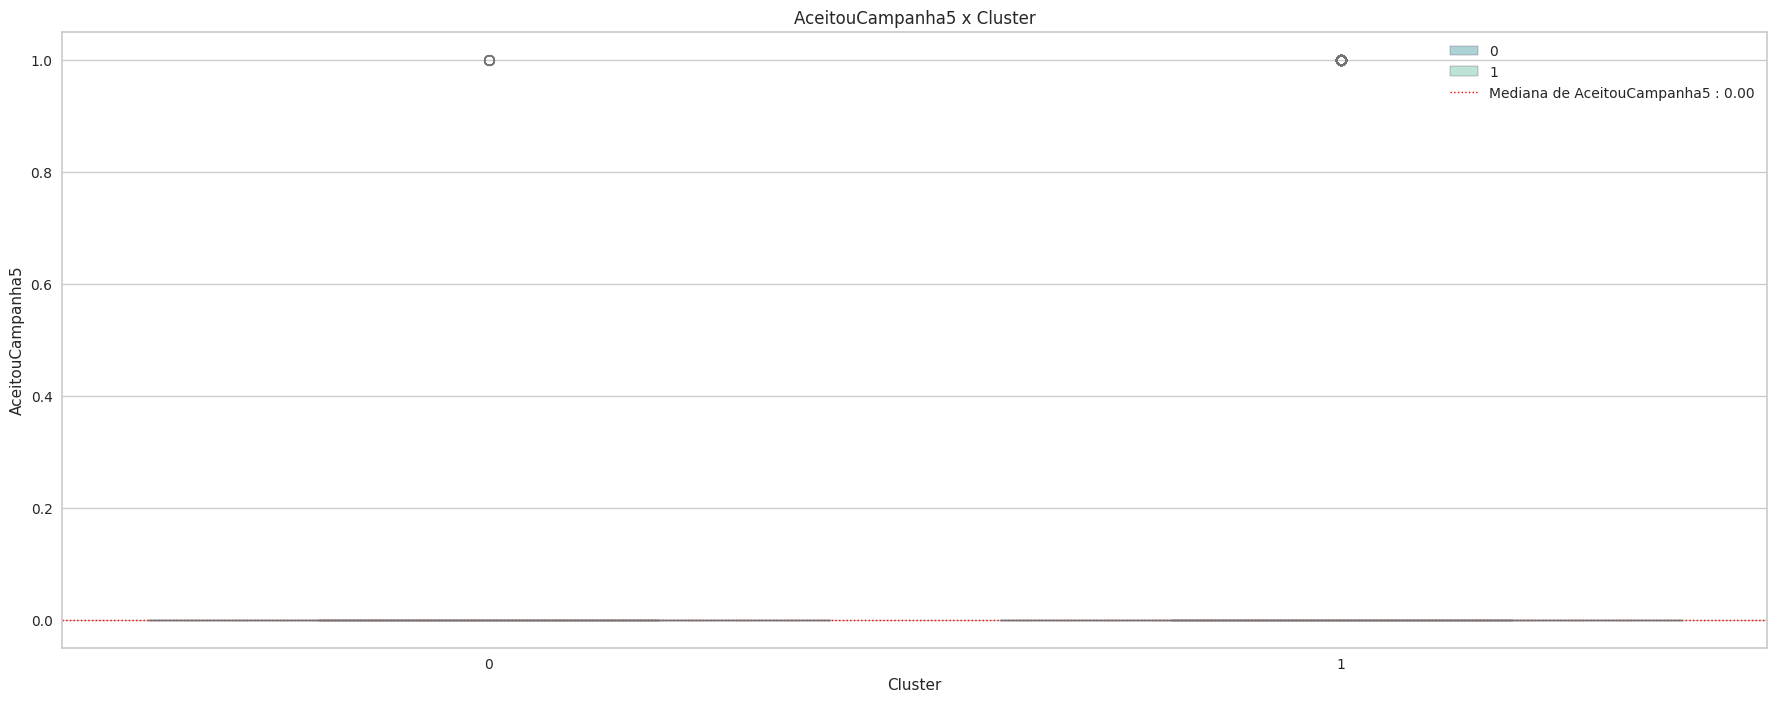

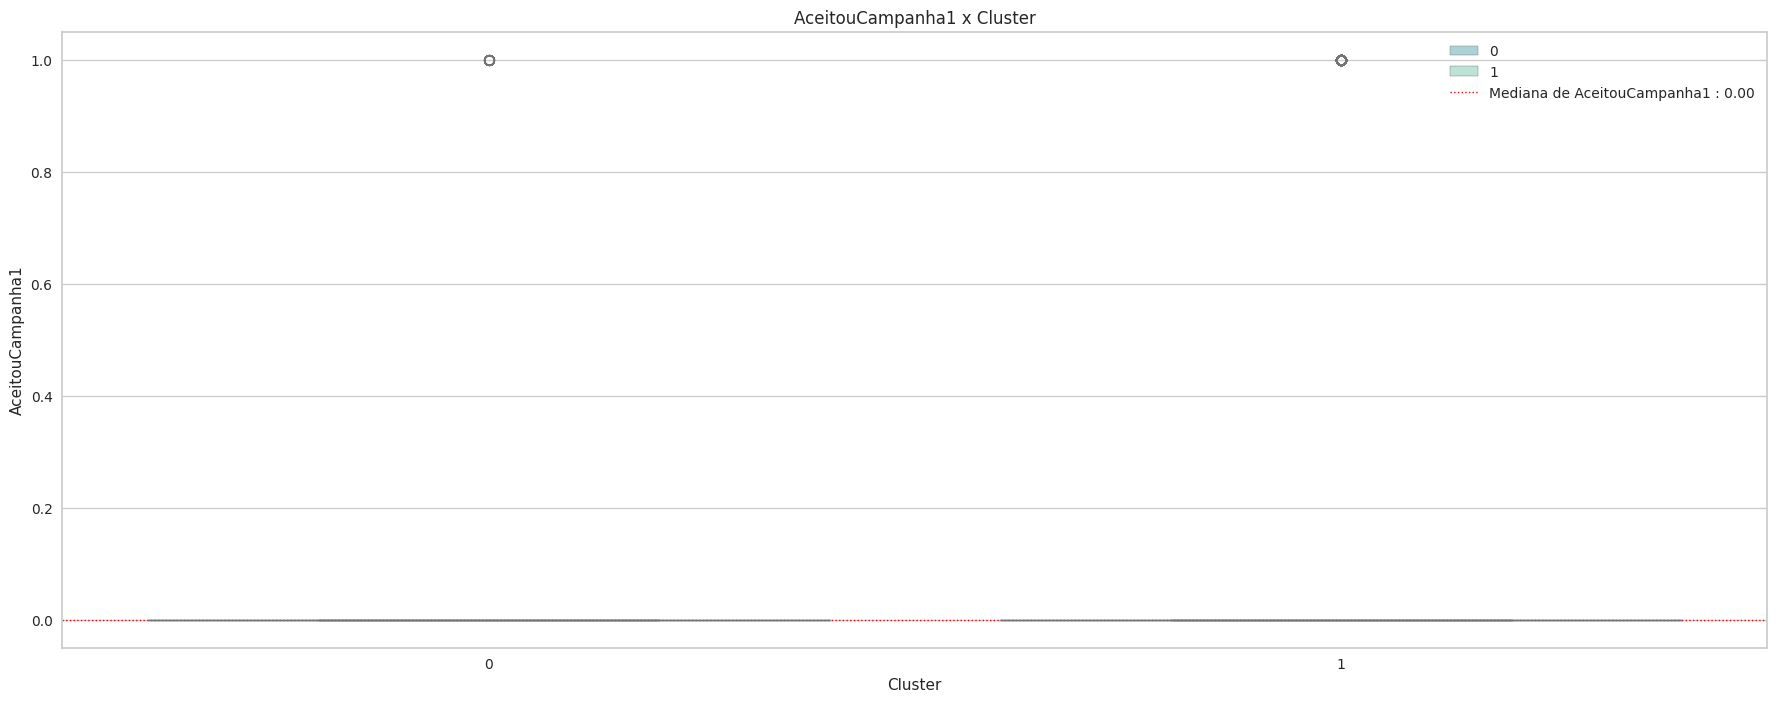

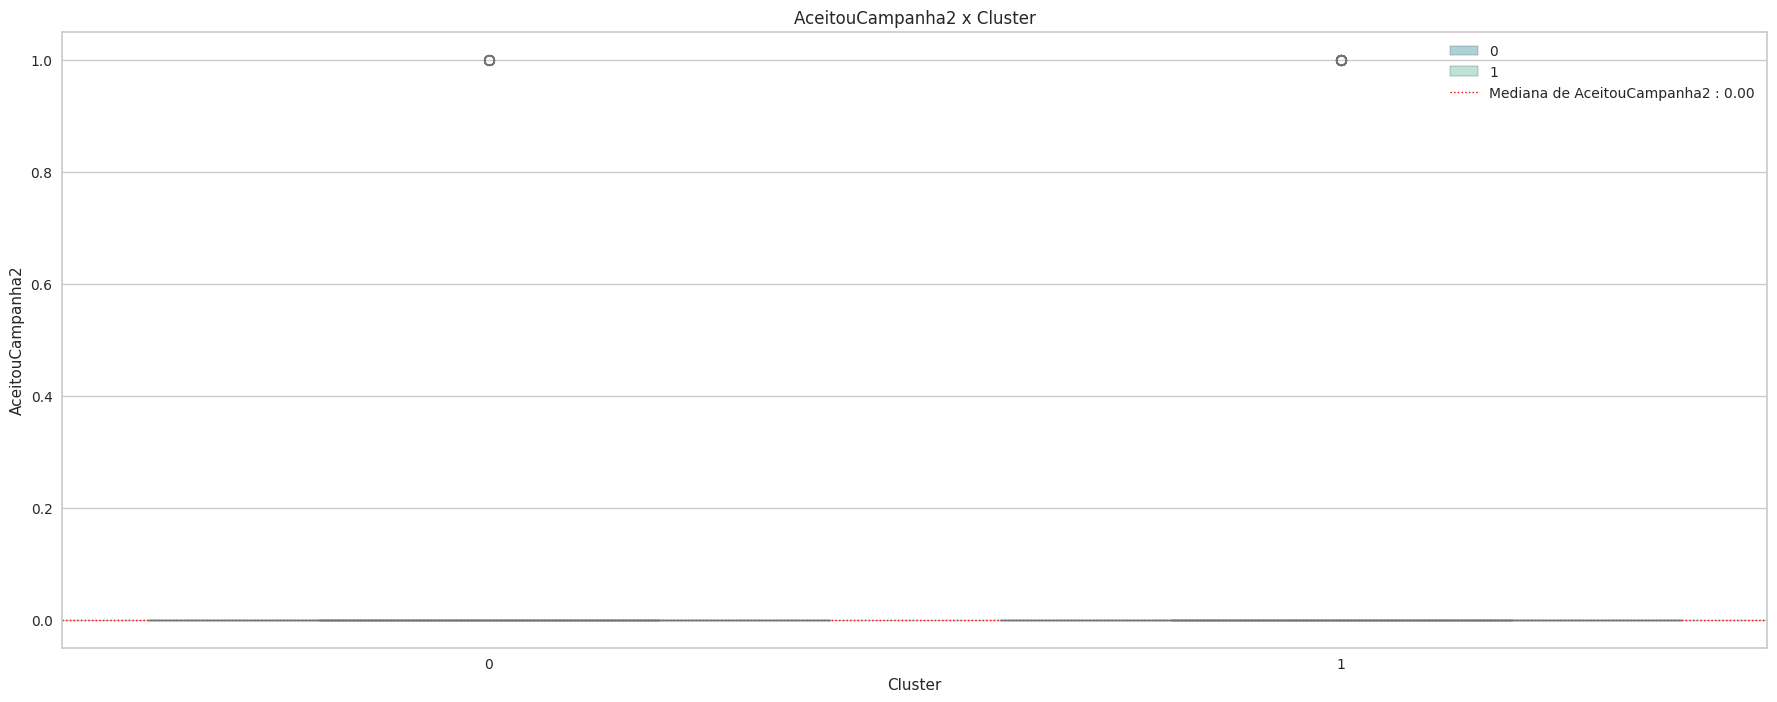

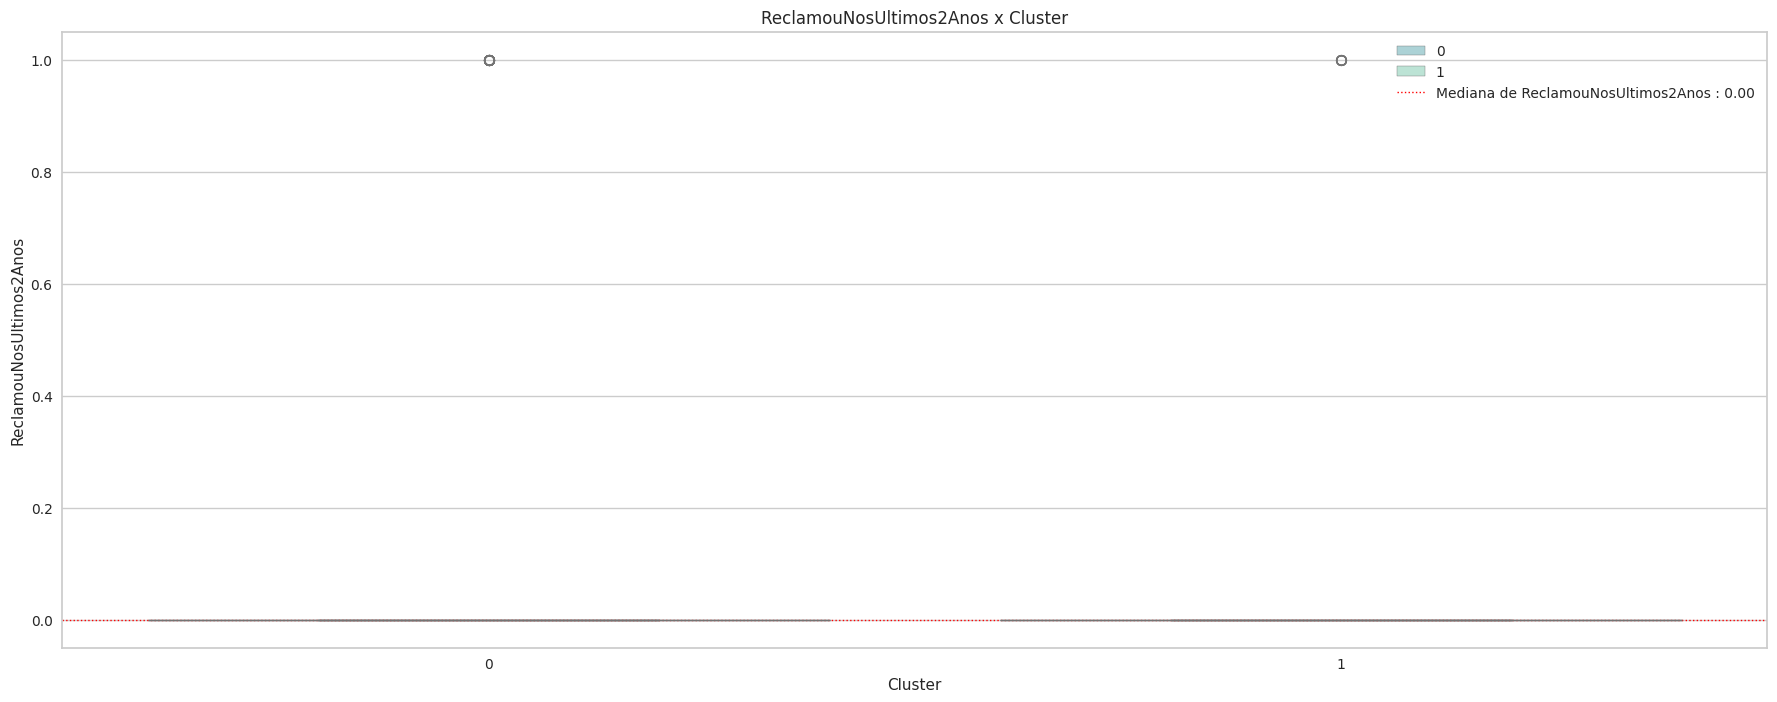

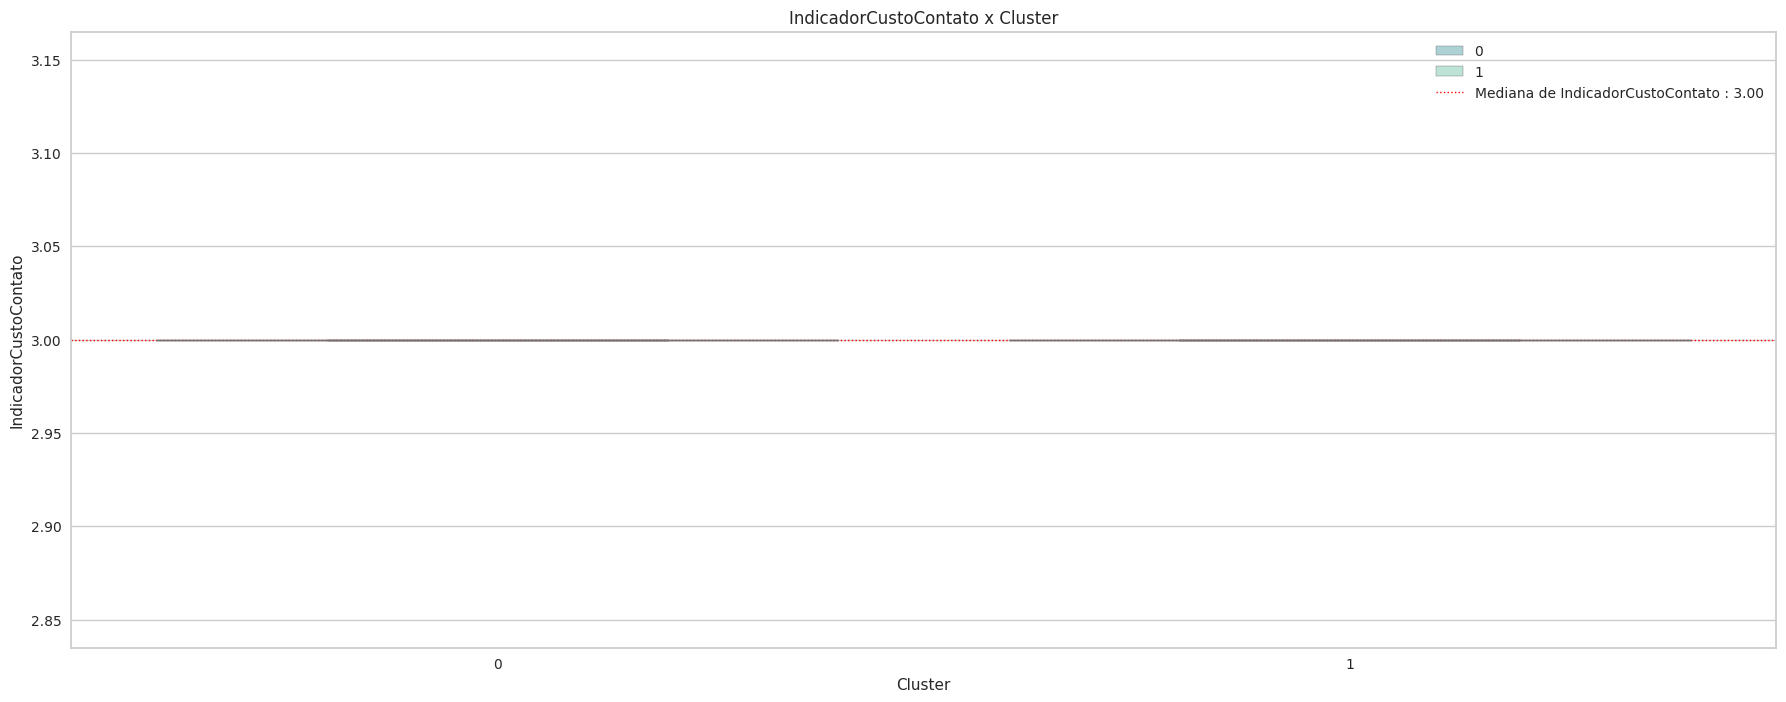

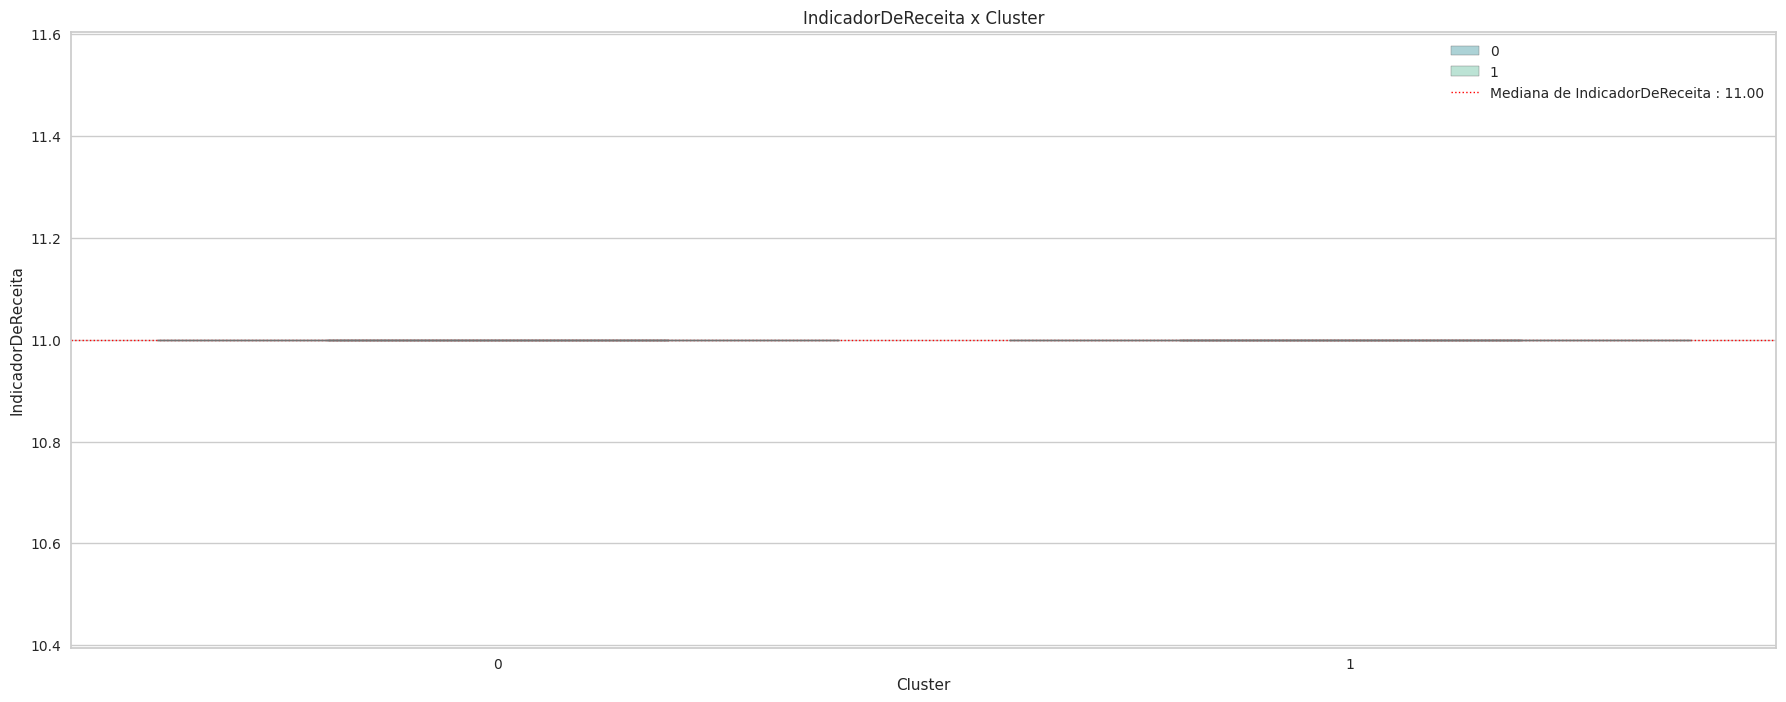

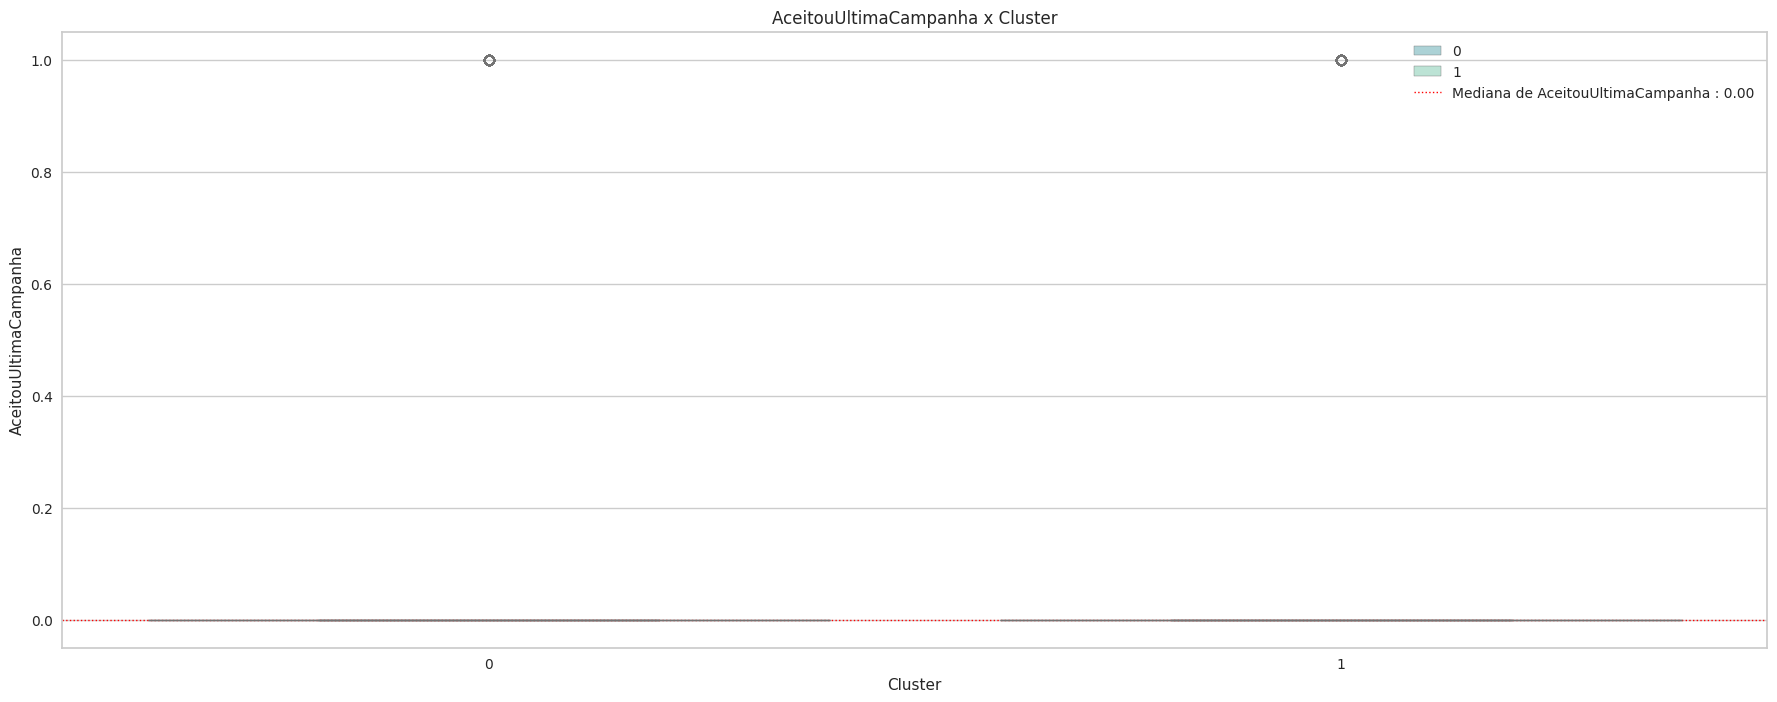

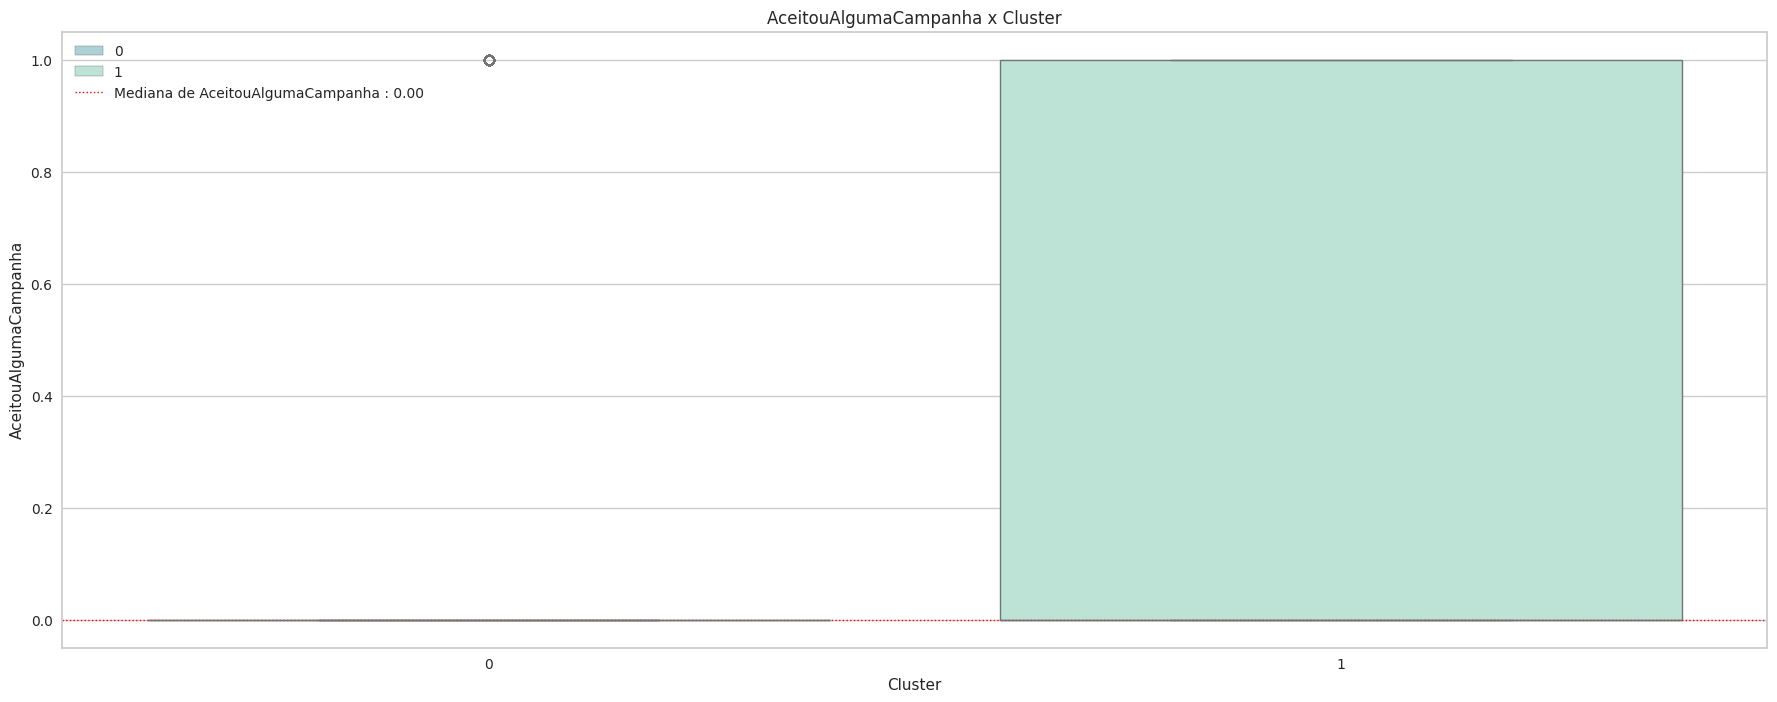

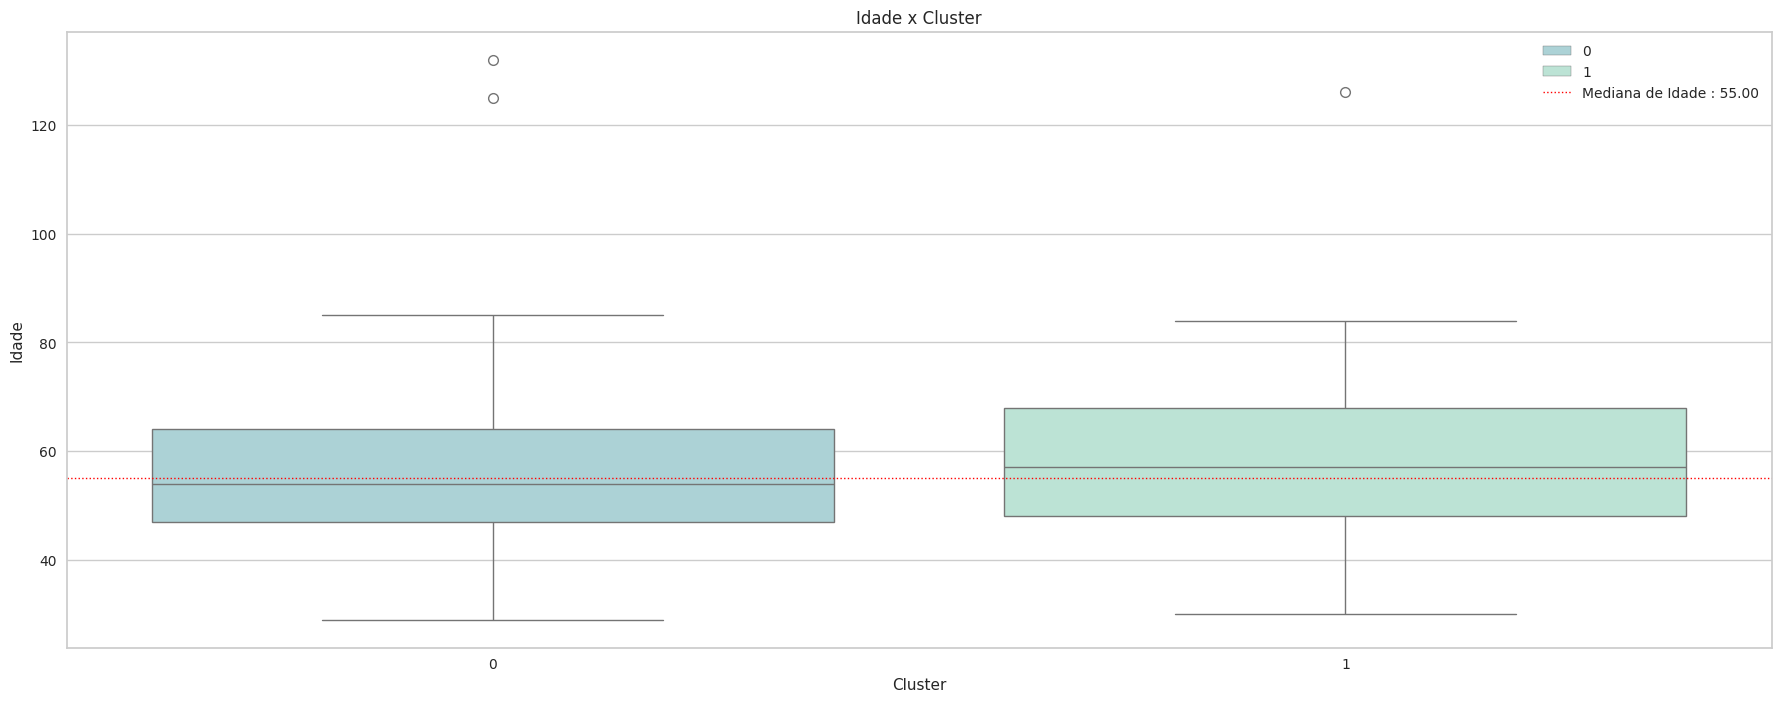

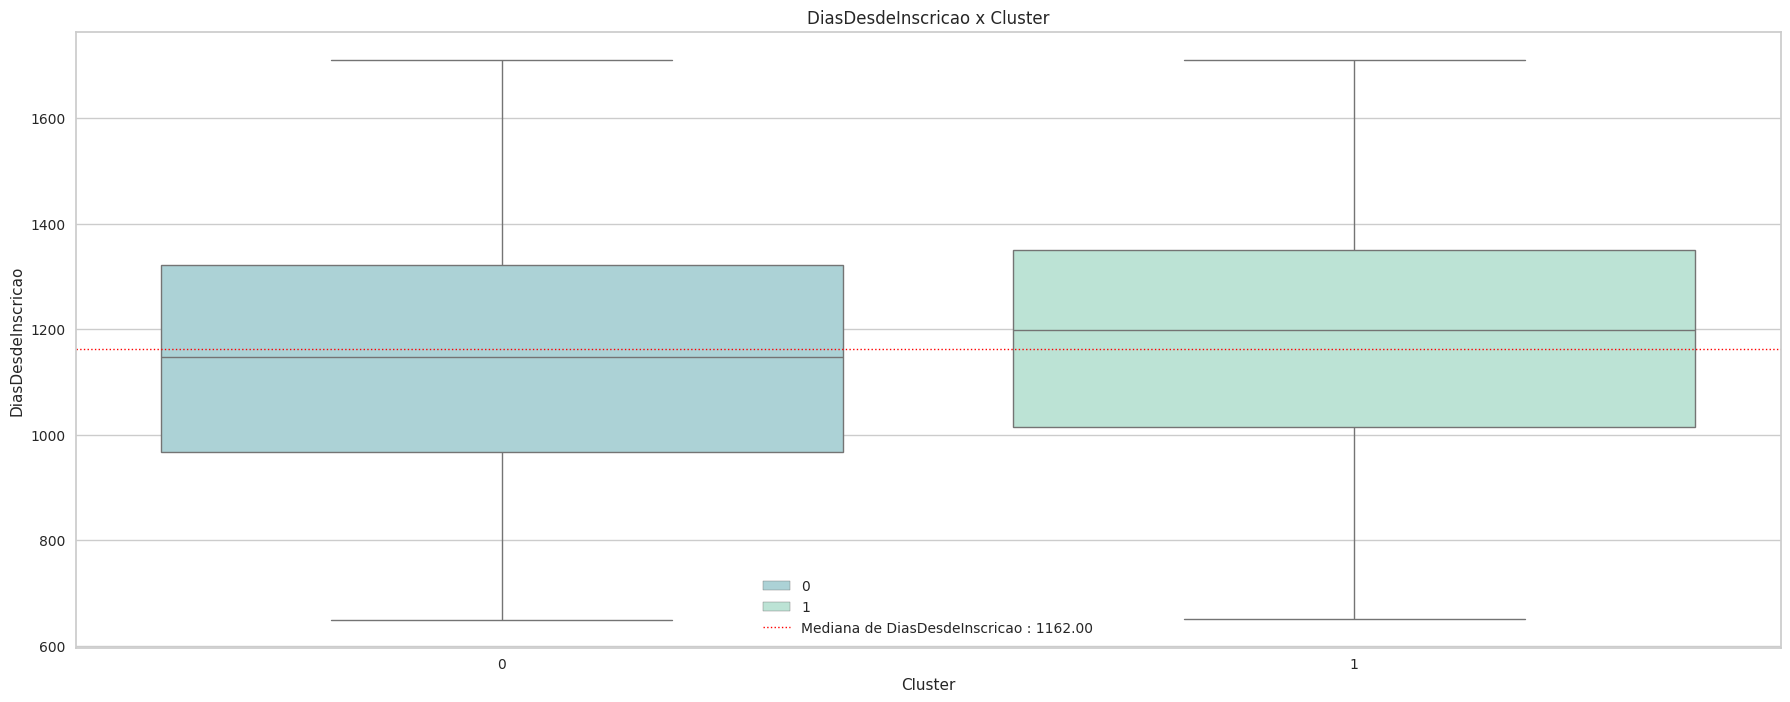

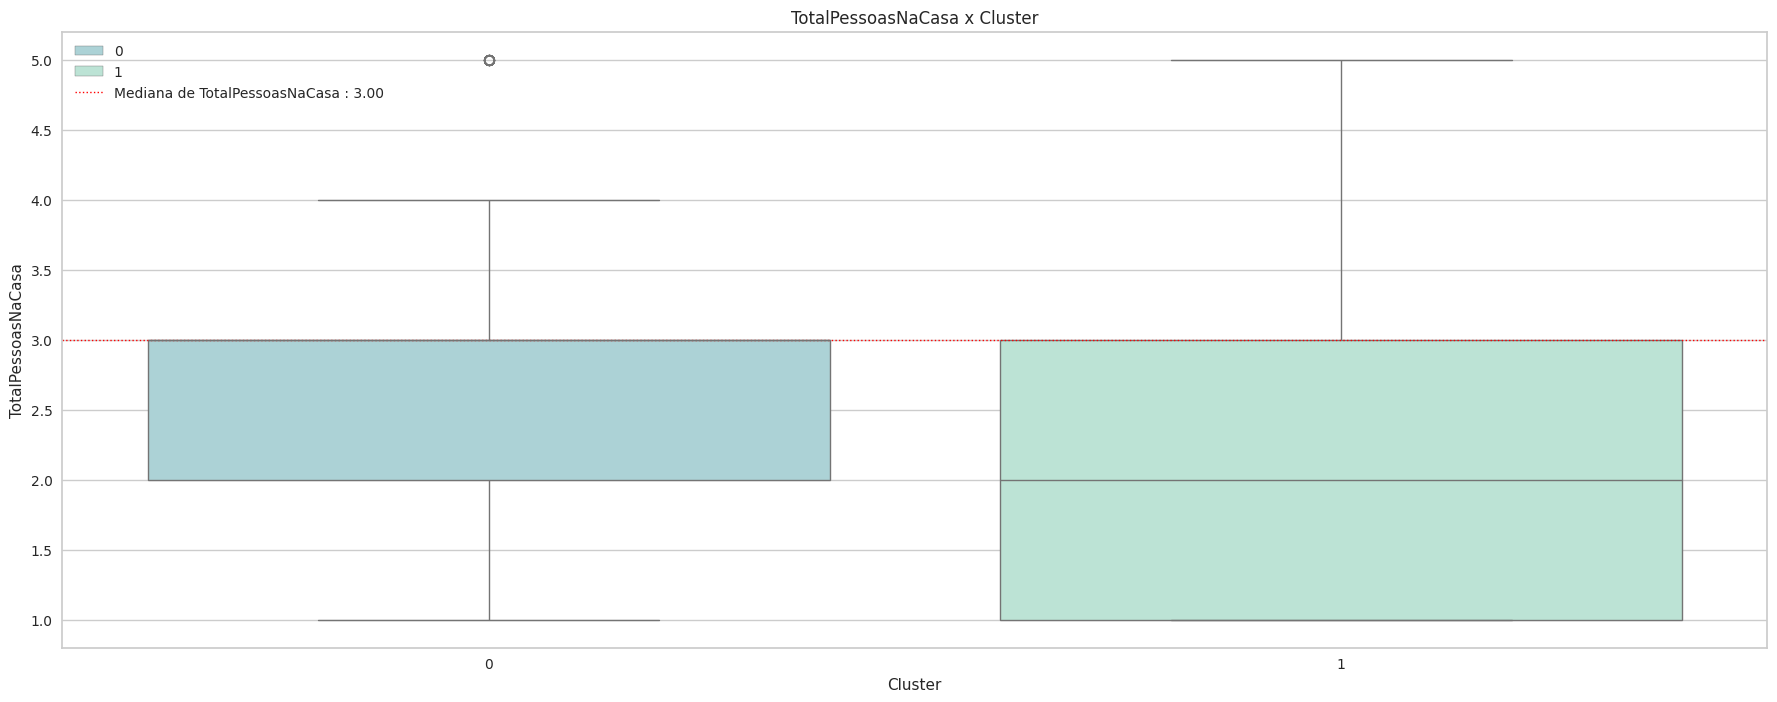

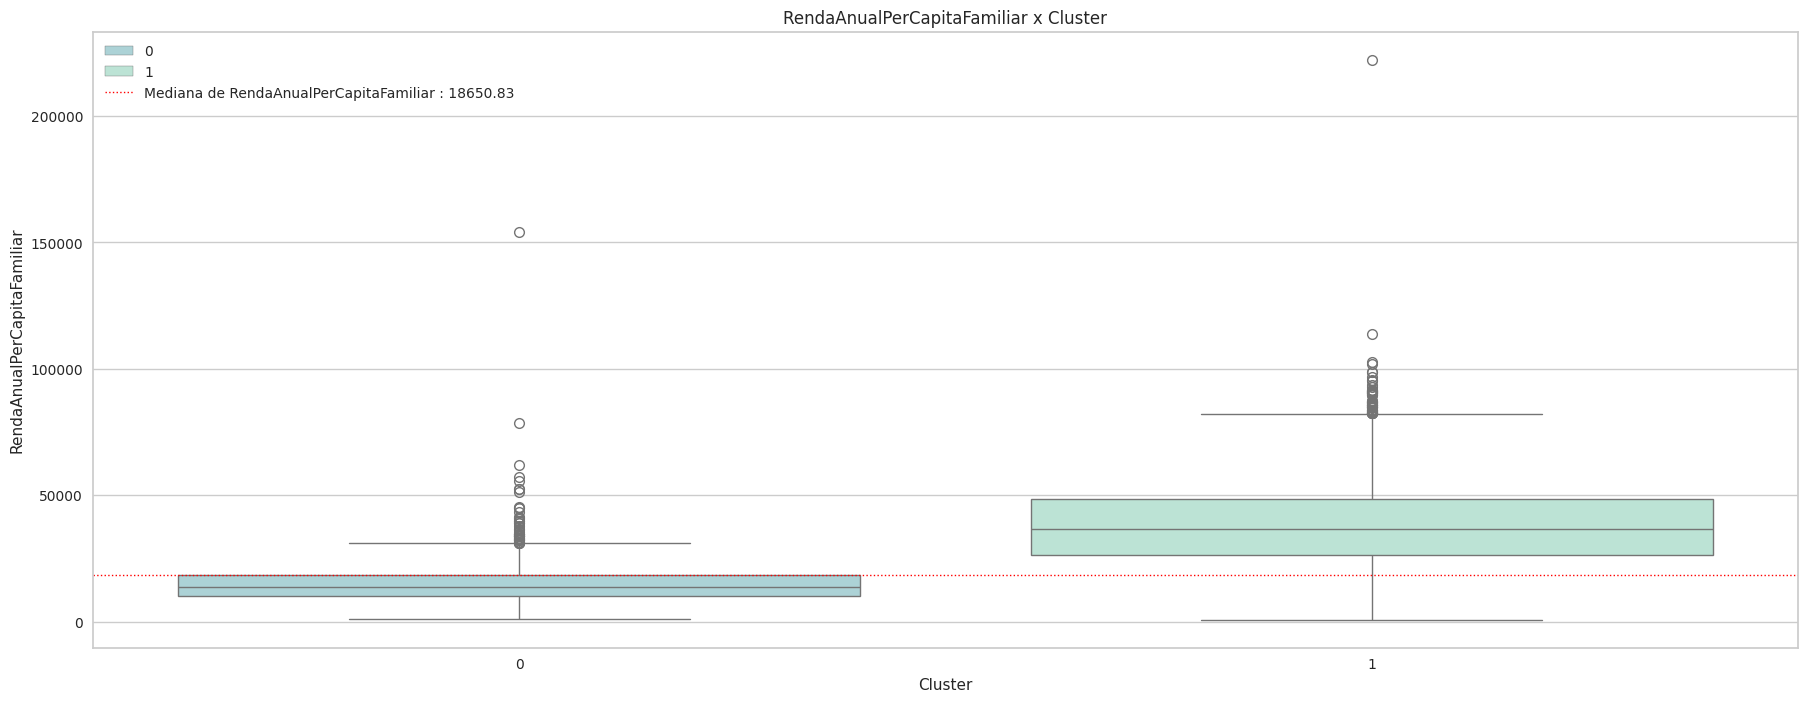

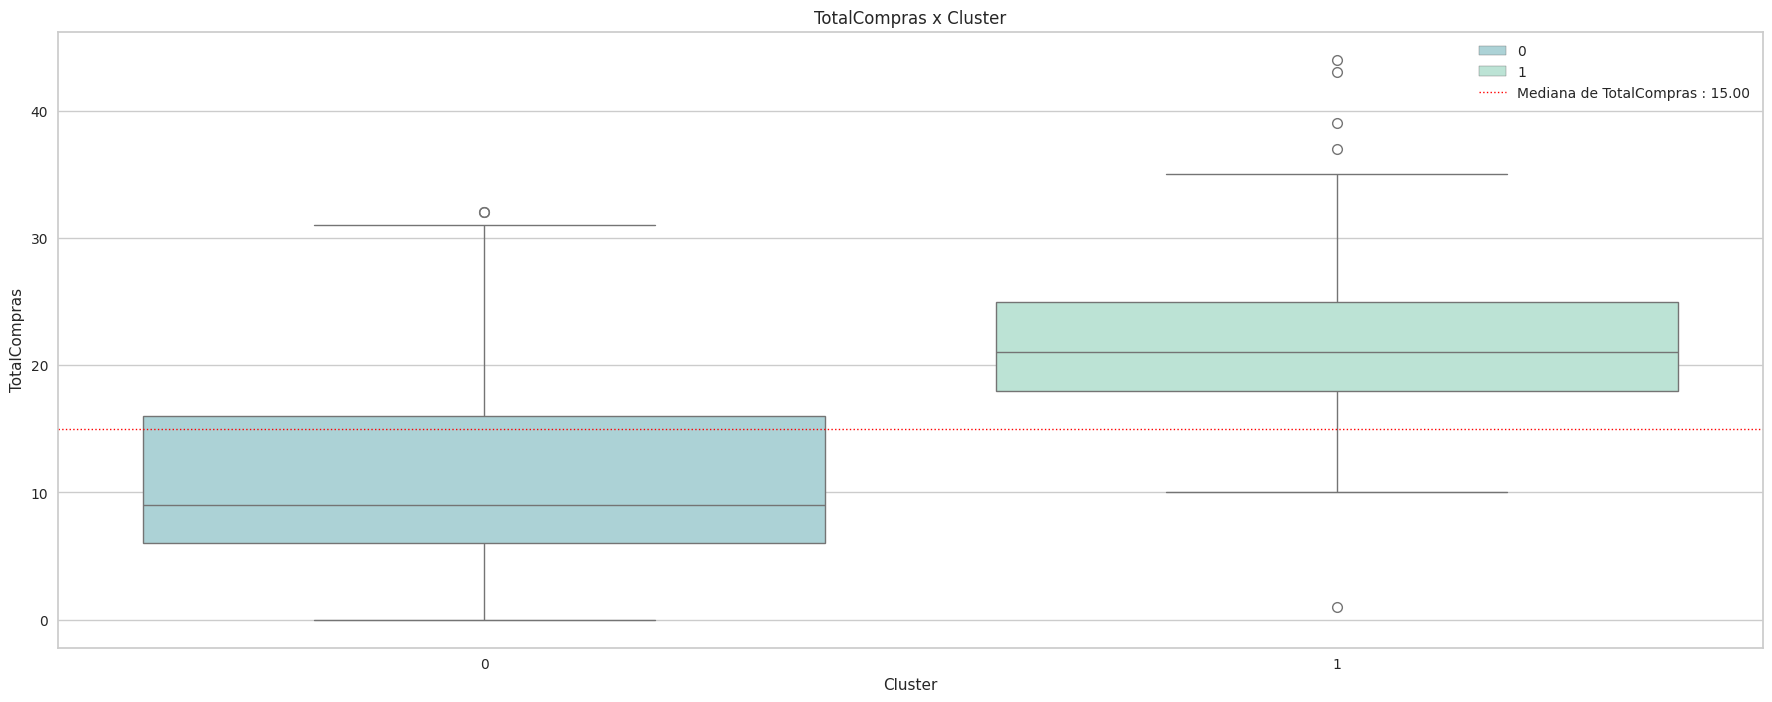

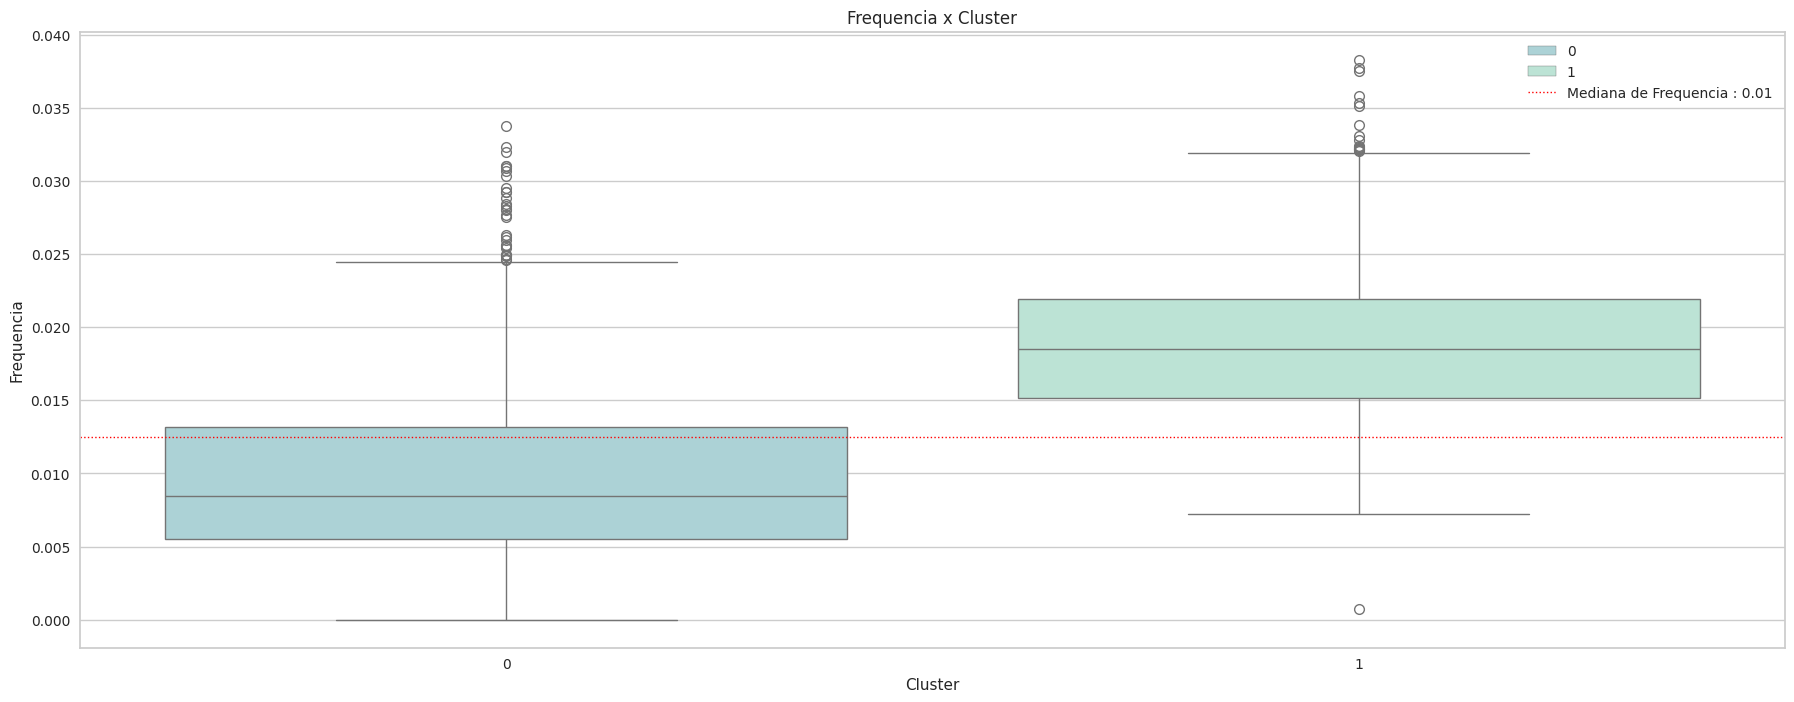

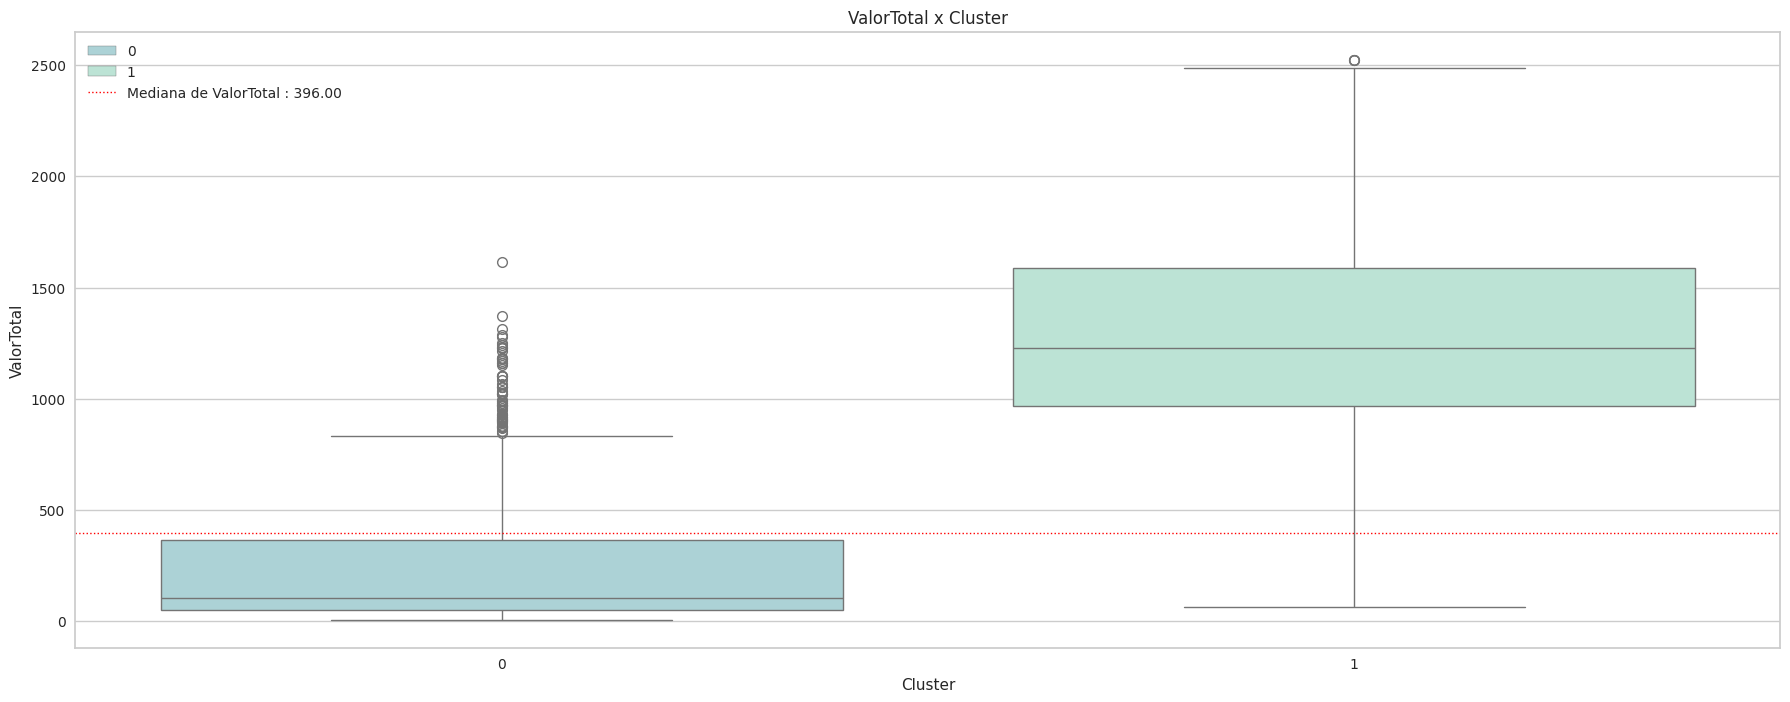

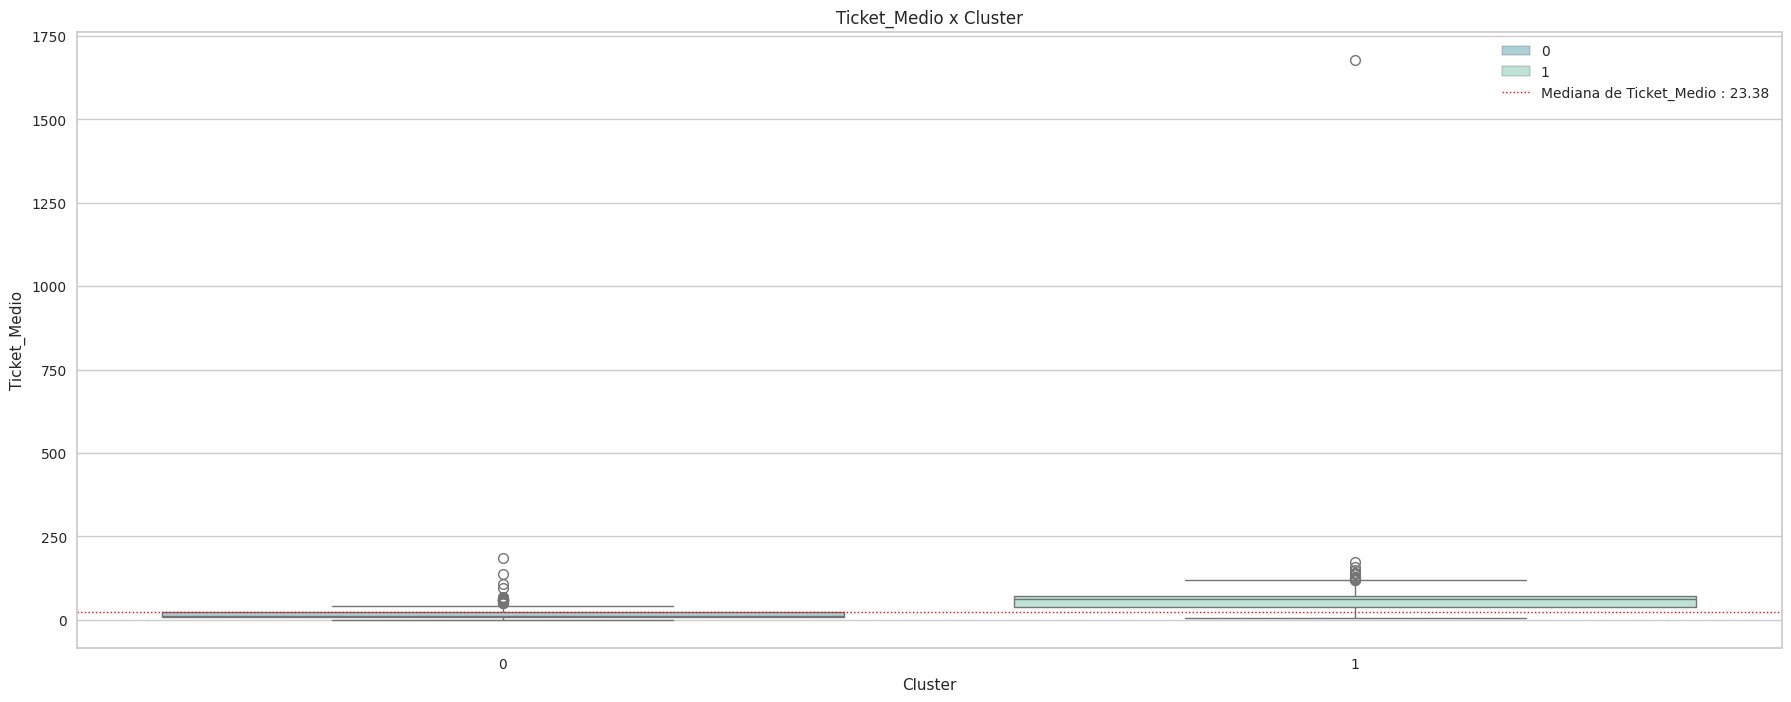

In [24]:
vars2 = list(num_attributes.columns).copy()

vars_numericas = vars2

for var in vars_numericas:
  plt.figure(figsize=(22, 8))
  pl=sns.boxplot(x=df["Cluster"], y=df[var], palette= pal, hue=df["Cluster"])

  mediana = df[var].median()
  # Adicionando uma linha indicando a média da variável de aceitacao
  text = f'Mediana de {var} :'+' {:.2f}'.format(mediana)
  plt.axhline(mediana, color='red', linestyle='dotted', linewidth=1, label=text)

  pl.set_title(f"{var} x Cluster")
  plt.legend()
  plt.show()

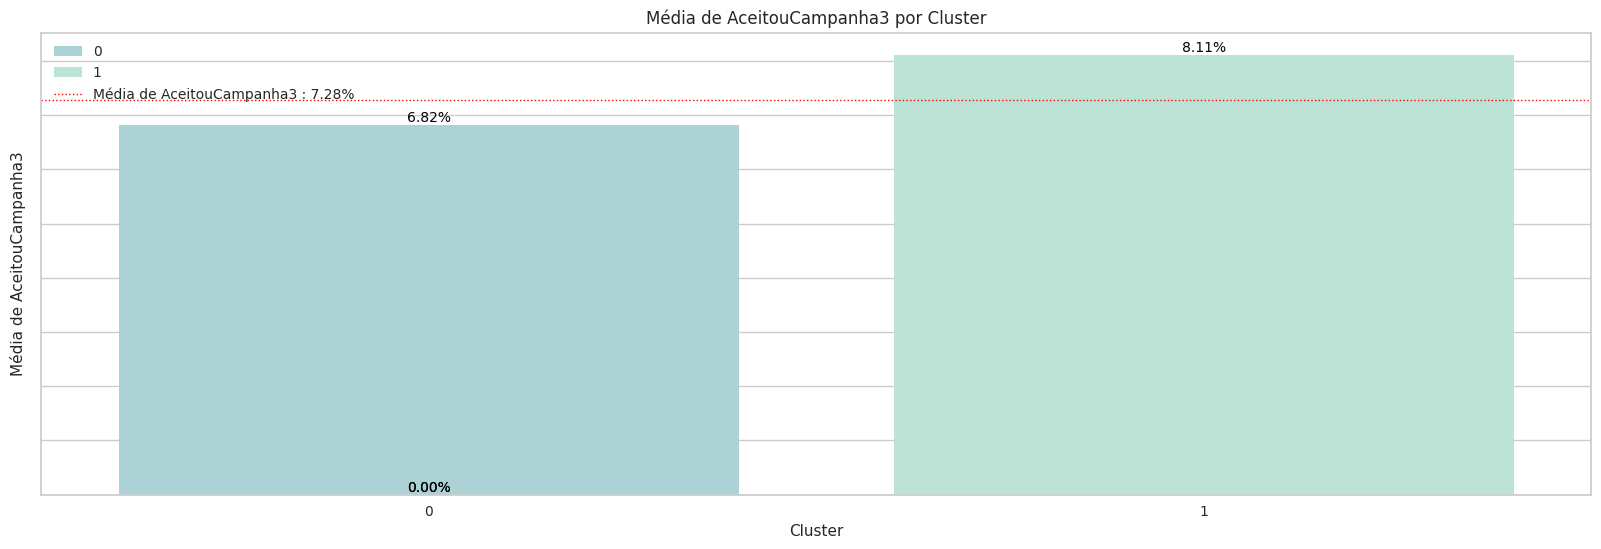

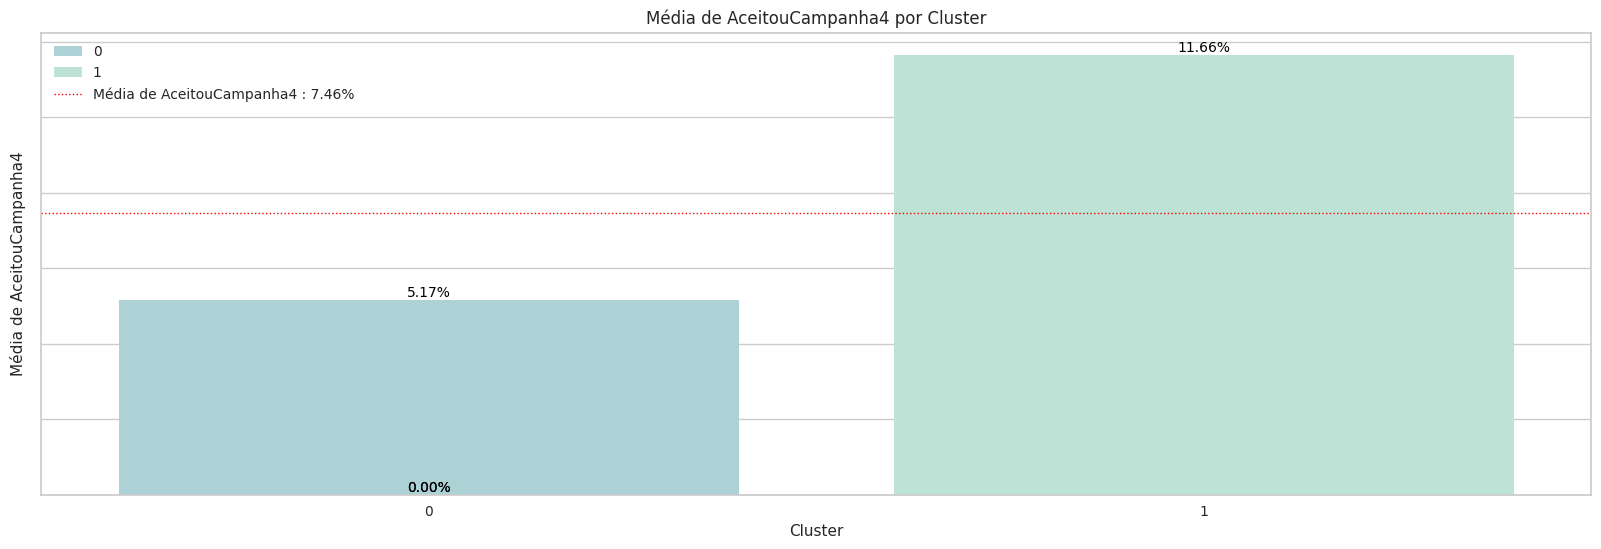

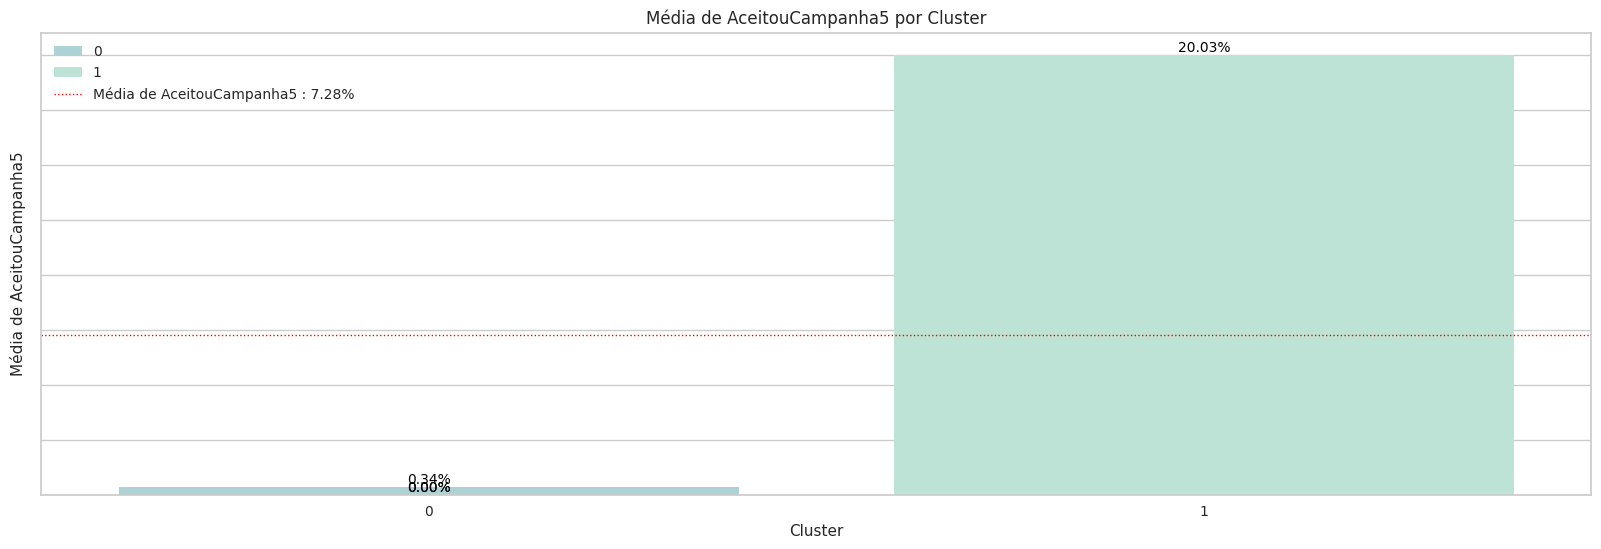

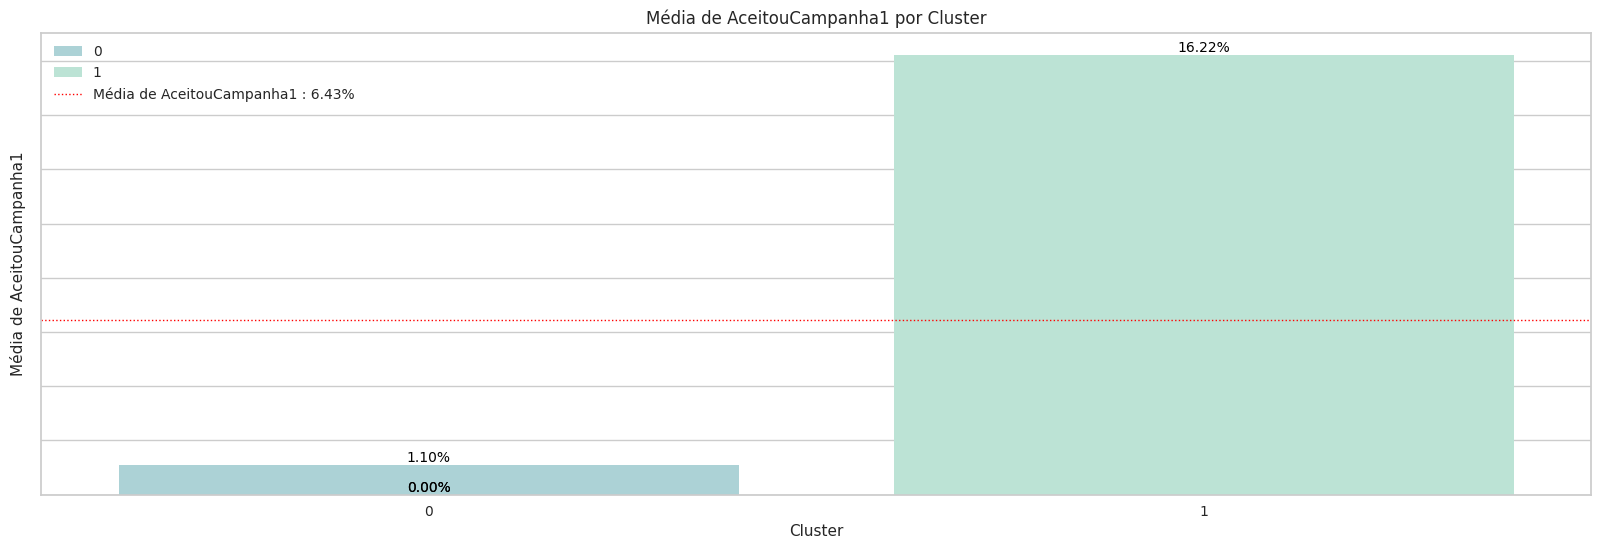

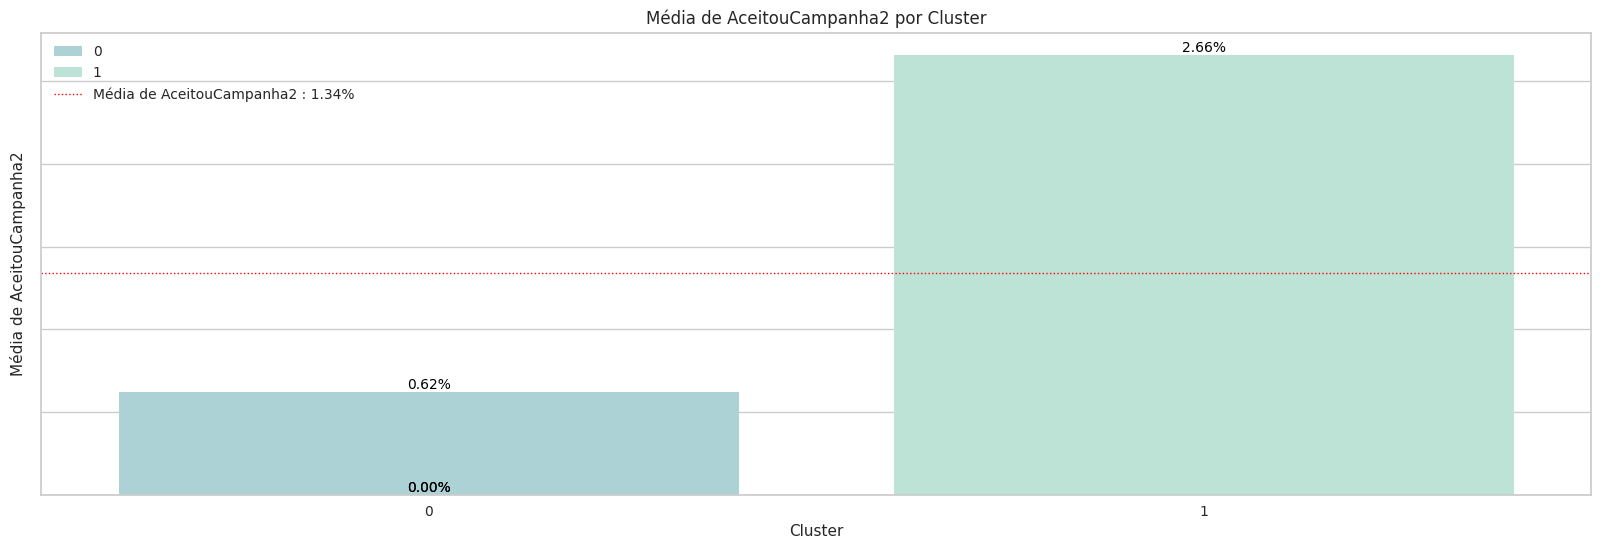

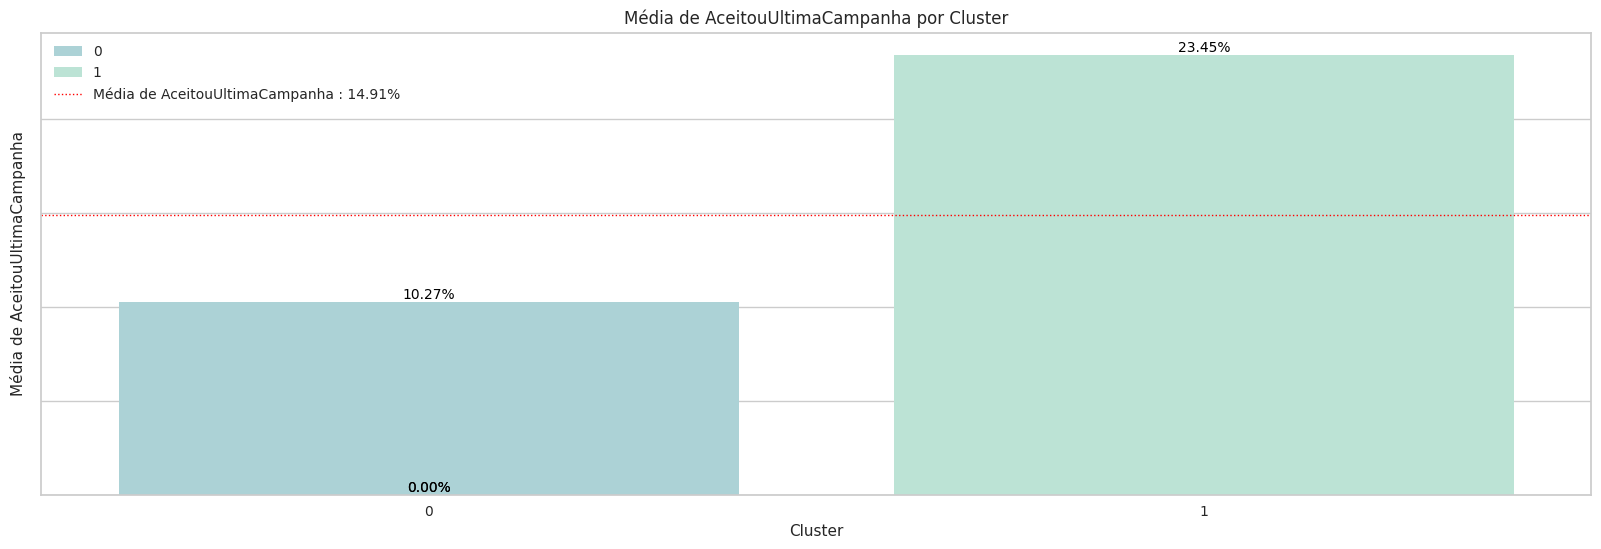

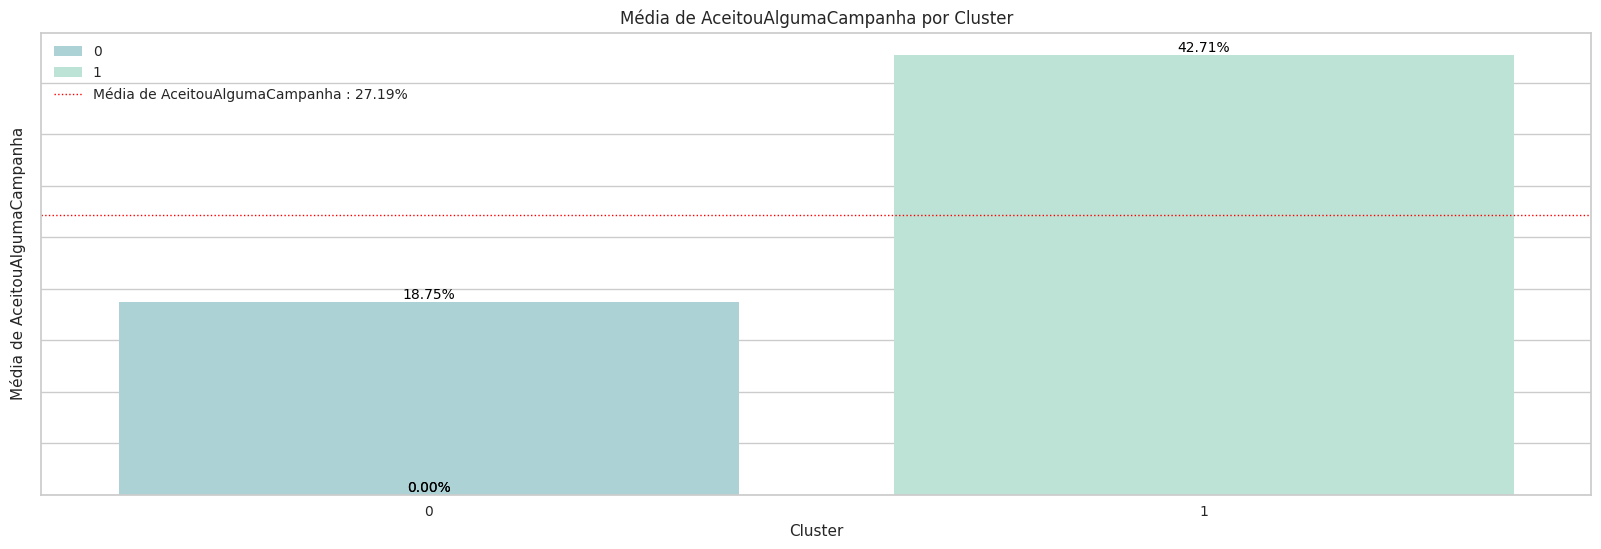

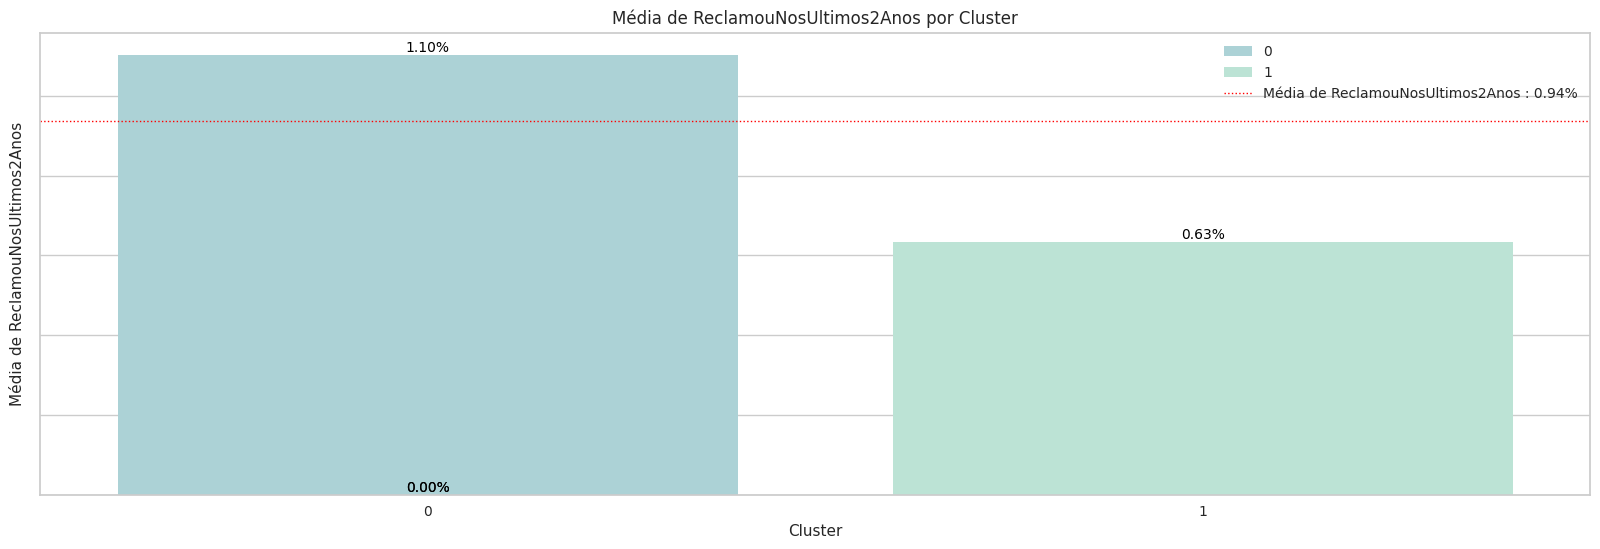

In [25]:
filtered_vars = [var for var in vars2 if 'AceitouCampanha' in var or 'AceitouUltimaCampanha' in var or 'AceitouAlgumaCampanha' in var]
filtered_vars.append('ReclamouNosUltimos2Anos')

for var in filtered_vars:
    plt.figure(figsize=(20, 6))
    ax = sns.barplot(data=df, x='Cluster', y=var, estimator='mean', errorbar=None, palette= pal, hue='Cluster')
    plt.title(f"Média de {var} por Cluster")
    plt.xlabel('Cluster')
    plt.ylabel(f'Média de {var}')

    media = df[var].mean()
    # Adicionando uma linha indicando a média da variável de aceitacao
    text = f'Média de {var} :'+' {:.2f}%'.format(100*media)
    plt.axhline(media, color='red', linestyle='dotted', linewidth=1, label=text)

    # Adicionando os valores no topo de cada barra
    for p in ax.patches:
        ax.annotate(f'{100*p.get_height():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=10, color='black',
                    xytext=(0, 5),
                    textcoords='offset points')
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.legend()
    plt.show()

In [30]:
df.query("Cluster == 1").describe()

,IDCliente,AnoDeNascimento,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DataDeInscricao,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,GastoComFrutasNosUltimos2Anos,GastoComCarneNosUltimos2Anos,GastoComPeixeNosUltimos2Anos,GastoComDocesNosUltimos2Anos,GastoComOuroNosUltimos2Anos,ComprasComDesconto,ComprasNoWeb,ComprasPorCatalogo,ComprasNaLoja,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha,AceitouAlgumaCampanha,Idade,DiasDesdeInscricao,TotalPessoasNaCasa,RendaAnualPerCapitaFamiliar,TotalCompras,Frequencia,ValorTotal,Ticket_Medio,Cluster,TARGET
count,789.000000,789.000000,782.000000,789.000000,789.000000,789,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.0,789.0,789.000000,789.000000,789.000000,789.00000,789.000000,782.000000,789.000000,789.000000,789.000000,789.000000,789.0,789.000000
mean,5593.588086,1967.468948,73569.223785,0.065906,0.349810,2022-06-19 15:36:16.425855488,49.830165,602.494297,61.467681,392.812421,87.697085,63.693283,79.143219,1.840304,5.656527,5.566540,8.572877,3.486692,0.081115,0.116603,0.200253,0.162231,0.026616,0.006337,3.0,11.0,0.234474,0.427123,57.531052,1183.34981,2.024081,43102.840644,21.636248,0.018881,1287.307985,64.263543,1.0,0.427123
min,0.000000,1899.000000,2447.000000,0.000000,0.000000,2021-01-08 00:00:00,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,30.000000,650.00000,1.000000,815.666667,1.000000,0.000726,62.000000,5.636364,1.0,0.000000
25%,2807.000000,1957.000000,65489.000000,0.000000,0.000000,2022-01-03 00:00:00,25.000000,358.000000,23.000000,206.000000,36.000000,24.000000,32.000000,1.000000,4.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,48.000000,1014.00000,1.000000,26258.750000,18.000000,0.015192,969.000000,39.850000,1.0,0.000000
50%,5453.000000,1968.000000,72639.000000,0.000000,0.000000,2022-06-04 00:00:00,51.000000,556.000000,48.000000,350.000000,73.000000,49.000000,58.000000,1.000000,5.000000,5.000000,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,57.000000,1199.00000,2.000000,36701.000000,21.000000,0.018519,1228.000000,62.437500,1.0,0.000000
75%,8537.000000,1977.000000,80419.750000,0.000000,1.000000,2022-12-06 00:00:00,74.000000,823.000000,90.000000,535.000000,132.000000,95.000000,117.000000,2.000000,7.000000,7.000000,11.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,1.000000,68.000000,1351.00000,3.000000,48701.250000,25.000000,0.021934,1586.000000,71.947368,1.0,1.000000
max,11112.000000,1995.000000,666666.000000,2.000000,2.000000,2023-12-05 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,1.000000,126.000000,1711.00000,5.000000,222222.000000,44.000000,0.038285,2525.000000,1679.000000,1.0,1.000000
std,3229.879824,12.815386,24827.402295,0.253335,0.500574,NaN,28.958426,321.760176,48.589632,247.555635,64.415161,50.481989,61.555501,1.803788,2.587043,2.862712,2.937820,2.088496,0.273185,0.321151,0.400444,0.368896,0.161060,0.079404,0.0,0.0,0.423938,0.494974,12.815386,229.15890,0.761163,22177.003666,4.813871,0.005156,425.291569,62.858813,0.0,0.494974


In [31]:
df.query("Cluster == 0").describe()

,IDCliente,AnoDeNascimento,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DataDeInscricao,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,GastoComFrutasNosUltimos2Anos,GastoComCarneNosUltimos2Anos,GastoComPeixeNosUltimos2Anos,GastoComDocesNosUltimos2Anos,GastoComOuroNosUltimos2Anos,ComprasComDesconto,ComprasNoWeb,ComprasPorCatalogo,ComprasNaLoja,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha,AceitouAlgumaCampanha,Idade,DiasDesdeInscricao,TotalPessoasNaCasa,RendaAnualPerCapitaFamiliar,TotalCompras,Frequencia,ValorTotal,Ticket_Medio,Cluster,TARGET
count,1451.000000,1451.000000,1434.000000,1451.000000,1451.000000,1451,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.0,1451.0,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1434.000000,1451.000000,1451.000000,1451.000000,1447.000000,1451.0,1451.000000
mean,5591.383184,1969.532736,40619.788006,0.649897,0.591316,2022-07-24 02:28:51.771192576,48.717436,141.590627,7.180565,44.134390,10.243970,7.144728,24.924190,2.588560,3.230186,1.082702,4.277050,6.311509,0.068229,0.051688,0.003446,0.011027,0.006203,0.011027,3.0,11.0,0.102688,0.187457,55.467264,1148.896623,2.905582,15117.369014,11.178498,0.009942,235.218470,16.464502,0.0,0.187457
min,1.000000,1893.000000,1730.000000,0.000000,0.000000,2021-01-08 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,29.000000,649.000000,1.000000,1005.750000,0.000000,0.000000,5.000000,0.533333,0.0,0.000000
25%,2832.500000,1961.000000,29672.000000,0.000000,0.000000,2022-02-01 00:00:00,24.000000,12.000000,1.000000,10.000000,2.000000,0.000000,5.000000,1.000000,1.000000,0.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,47.000000,967.500000,2.000000,10113.812500,6.000000,0.005513,47.000000,7.400000,0.0,0.000000
50%,5474.000000,1971.000000,39878.000000,1.000000,1.000000,2022-07-26 00:00:00,49.000000,42.000000,3.000000,23.000000,4.000000,3.000000,14.000000,2.000000,3.000000,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,54.000000,1147.000000,3.000000,13600.750000,9.000000,0.008488,103.000000,13.000000,0.0,0.000000
75%,8401.000000,1978.000000,51369.000000,1.000000,1.000000,2023-01-21 12:00:00,74.000000,184.500000,9.000000,64.000000,13.000000,9.000000,30.000000,3.000000,4.000000,2.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,64.000000,1322.000000,3.000000,18528.250000,16.000000,0.013147,362.500000,22.431818,0.0,0.000000
max,11191.000000,1996.000000,162397.000000,2.000000,2.000000,2023-12-06 00:00:00,99.000000,1279.000000,103.000000,375.000000,150.000000,109.000000,321.000000,15.000000,25.000000,8.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,1.000000,132.000000,1711.000000,5.000000,153924.000000,32.000000,0.033742,1616.000000,186.500000,0.0,1.000000
std,3256.862230,11.446041,16129.481799,0.540847,0.548761,NaN,28.967094,209.302172,10.994566,50.126329,15.452522,10.921084,33.270715,1.949247,2.492073,1.286019,2.263751,1.977319,0.252225,0.221474,0.058621,0.104464,0.078539,0.104464,0.0,0.0,0.303655,0.390412,11.446041,233.025786,0.825484,8357.470116,6.314120,0.005668,267.615949,13.208660,0.0,0.390412
